# Playing with stop words

Nb common words seems to be an interesting feature.

But isn'it disturbed by common words like do, not, and which may precisely be common to many pairs, this without any significance ?

So, if we remove stop words, nb common feature may have more significance


In [1]:
# Ugly incantation to make our 'framework' working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='clean_data'
# Do a bit of checks before actually running long code
UNITARY_TEST = True
print_alert('You will use environment %s' % EXPERIMENT)

prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

## Challenge and training are not equivalent

% of duplicate in training is not the same in challenge !
We don't have the challenge's answer but by scoring a constant prediction and using logloss definition, we can guess the distribution of duplicates in challenge

It's 17.46 %

To fix that we can:

* duplicate some negative cases in training to match challenge distribution
* use weights : each case has a weight !=1 and all algorithms are supposed to be able to deal with that info
I choose to use weights (less memory needed ?)

In [2]:
# return the weight for 0 and weight for 1 needed to rebalance dataframe like challenge
def balanced_weights(dataframe,expected_positive_ratio):
    current_positive_ratio = dataframe['is_duplicate'].sum()/len(dataframe)
    weight_for_negative = (1-expected_positive_ratio)/(1-current_positive_ratio)
    weight_for_positive = expected_positive_ratio/current_positive_ratio
    return weight_for_positive,weight_for_negative
    return 1,


CHALLENGE_DUPLICATE_PERCENT = 0.1746
print_warning('OUPS !! %% of duplicates in train is %.3f. In challenge it is %.3f %%' % (train_dataframe['is_duplicate'].sum()/len(train_dataframe),CHALLENGE_DUPLICATE_PERCENT))

# create a new 'weight' column to training dataset
# Do not forget to remove this column from features !!!
print_warning("let's add some weights to rebalance the data")
weight_for_1,weight_for_0 = balanced_weights(train_dataframe,CHALLENGE_DUPLICATE_PERCENT)
print_info('Weight for positive case %.3f' % weight_for_1)
print_info('Weight for negative case %.3f' % weight_for_0)
train_dataframe['weight'] = train_dataframe['is_duplicate'].map( {0:weight_for_0, 1:weight_for_1})

assert int(train_dataframe['weight'].sum()/len(train_dataframe)) == 1, "training dataset has not been properly rebalanced"
print_info("Training data set has been properly rebalanced")
print_info('Weights distribution:')
train_dataframe['weight'].describe()

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

count    404290.000000
mean          1.000000
std           0.403239
min           0.472917
25%           0.472917
50%           1.308493
75%           1.308493
max           1.308493
Name: weight, dtype: float64

# Ready to start

In [3]:
# our main tool to add feature
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]

### Step 1: lower case everything

Note we definitely get rid of any information related to majus case

In [4]:
def build_all_lower_data(dataframe):
    print_info('Lower case question1')
    dataframe['question1'] = dataframe['question1'].str.lower()
    print_info('Lower case question2')
    dataframe['question2'] = dataframe['question2'].str.lower()
    return dataframe

print_section('Before')
display(train_dataframe.head(2).transpose())
train_dataframe = load_or_build_dataframe('Lower case everything in training','training_lower',build_all_lower_data,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Lower case everything in challenge','challenge_lower',build_all_lower_data,challenge_dataframe)
print_section('After')
display(train_dataframe.head(2).transpose())



&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,0,1
id,0,1
qid1,1,3
qid2,2,4
question1,What is the step by step guide to invest in share market in india?,What is the story of Kohinoor (Koh-i-Noor) Diamond?
question2,What is the step by step guide to invest in share market?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?
is_duplicate,0,0
weight,1.30849,1.30849


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,0,1
id,0,1
qid1,1,3
qid2,2,4
question1,what is the step by step guide to invest in share market in india?,what is the story of kohinoor (koh-i-noor) diamond?
question2,what is the step by step guide to invest in share market?,what would happen if the indian government stole the kohinoor (koh-i-noor) diamond back?
is_duplicate,0,0
weight,1.30849,1.30849


### Step 2 : build our basic features
* Nb words in question 1
* Nb words in question 2
* Nb common words
* Nb common words/nb words in question 1
* Nb common words/nb words in question 2
* Nb non common words in question 1
* Nb non common words in question 2
* Nb common words/(Nb words in question1 + Nb words in question2)

Note this is done on raw question content : no preprocessing

In [5]:
def build_basic_features_one_row(q1,q2):
    q1 = set(q1.split())
    len_q1 = len(q1)
    q2 = set(q2.split())
    len_q2 = len(q2)

    common = q1&q2
    len_common = len(common)

    uncommon_q1 = q1-common
    len_uncommon_q1 = len(uncommon_q1)

    uncommon_q2 = q2-common
    len_uncommon_q2 = len(uncommon_q2)
    #       0     1           2            3         4               5               6      7      8                        9                        10
    return common,uncommon_q1,uncommon_q2,len_common,len_uncommon_q1,len_uncommon_q2,len_q1,len_q2,len_common/max(1,len_q1),len_common/max(1,len_q2),len_common/(len_q1+len_q2)
    
def build_all_basic_features(dataframe):
    print_warning('Compute all features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: build_basic_features_one_row(r.question1,r.question2))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'nb_words_question2','temp',lambda x: x[7])

    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'nb_common_words/nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'nb_common_words/nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'nb_words_question1-common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'nb_words_question2-common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe


train_dataframe = load_or_build_dataframe('Training data + basic features','training_basic_features',build_all_basic_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge data + basic features','challenge_basic_features',build_all_basic_features,challenge_dataframe)


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

Let's take a look in our new data

In [6]:
train_dataframe.head(2).transpose()

,0,1
id,0,1
qid1,1,3
qid2,2,4
question1,what is the step by step guide to invest in share market in india?,what is the story of kohinoor (koh-i-noor) diamond?
question2,what is the step by step guide to invest in share market?,what would happen if the indian government stole the kohinoor (koh-i-noor) diamond back?
is_duplicate,0,0
weight,1.30849,1.30849
nb_words_question1,12,8
nb_words_question2,11,12
nb_common_words,10,4


Let's take a look in common words & uncommon_words_question1

In [7]:
train_dataframe[['common_words','uncommon_words_question1']]

,common_words,uncommon_words_question1
0,"{by, is, guide, share, to, what, step, in, the, invest}","{market, india?}"
1,"{what, the, kohinoor, (koh-i-noor)}","{diamond?, is, of, story}"
2,"{can, how, speed, internet}","{of, while, increase, using, the, my, connection, a, i, vpn?}"
3,{},"{mentally, why, how, it?, am, can, lonely?, i, very, solve}"
4,"{which, in}","{dissolve, salt,, water, carbon, and, one, methane, quikly, sugar,, oxide?, di}"
...,...,...
404285,"{are, there, how, latest, programming, in, the, keywords, language, many, version?}","{of, racket}"
404286,"{is, death?, life, there, after}","{do, you, believe}"
404287,{coin?},"{what, is, one}"
404288,{of},"{indian, is, what, student?, while, an, chicago,, approx, studying, uic, in, cost, the, for, living, annual}"


common words is 'polluted' by tons of word like is,with,to,...  stop words

### Step 3 : remove a first set of stop words

We start with stopwords coming from nltk


In [8]:
from nltk.corpus import stopwords

def build_no_stopwords_features_one_row(q1,q2,stopwords):
    q1 = set([w for w in q1.split() if w not in stopwords])
    len_q1 = len(q1)
    q2 = set([w for w in q2.split() if w not in stopwords])
    len_q2 = len(q2)

    common = q1&q2
    len_common = len(common)

    uncommon_q1 = q1-common
    len_uncommon_q1 = len(uncommon_q1)

    uncommon_q2 = q2-common
    len_uncommon_q2 = len(uncommon_q2)
    #       0     1           2            2         4               5               6      7      8                        9                        10
    return common,uncommon_q1,uncommon_q2,len_common,len_uncommon_q1,len_uncommon_q2,len_q1,len_q2,len_common/max(1,len_q1),len_common/max(1,len_q2),len_common/max(1,(len_q1+len_q2))
    

def build_nltk_stop_words_features(dataframe):
    print_warning('Remove stopwords from question 1 & question2')
    
    print_warning('Compute all nltk features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: build_no_stopwords_features_one_row(r.question1,r.question2,nltk_stopwords))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'nltk_nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'nltk_nb_words_question2','temp',lambda x: x[7])

    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'nltk_nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'nltk_nb_common_words/nltk_nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'nltk_nb_common_words/nltk_nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'nltk_nb_words_question1-nltk_common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'nltk_nb_words_question2-nltk_common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'nltk_common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'nltk_uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'nltk_uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe

nltk_stopwords = set(stopwords.words('english'))
print_info( 'There is %d stopwords in nltk' % len(nltk_stopwords))

train_dataframe = load_or_build_dataframe('Training: Build features aware of nltk stopwords','training_nltk_stop_words_features',build_nltk_stop_words_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge: Build features aware of nltk stopwords','challenge_nltk_stop_words_features',build_nltk_stop_words_features,challenge_dataframe)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

Did we change anything ?

In [9]:
nb_changed_train = int(numpy.where(train_dataframe['nltk_nb_common_words']!=train_dataframe['nb_common_words'],1,0).sum())
print_info('We have changed %.2f %% of nb common_words in training!!' % (nb_changed_train*100./len(train_dataframe)))
nb_changed_challenge = int(numpy.where(challenge_dataframe['nltk_nb_common_words']!=challenge_dataframe['nb_common_words'],1,0).sum())
print_info('We have changed %.2f %% of nb common_words in challenge !!' % (nb_changed_challenge*100./len(challenge_dataframe)))
train_dataframe[['common_words','nltk_common_words','uncommon_words_question1','nltk_uncommon_words_question1']].head(2)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,common_words,nltk_common_words,uncommon_words_question1,nltk_uncommon_words_question1
0,"{by, is, guide, share, to, what, step, in, the, invest}","{step, guide, share, invest}","{market, india?}","{market, india?}"
1,"{what, the, kohinoor, (koh-i-noor)}","{kohinoor, (koh-i-noor)}","{diamond?, is, of, story}","{story, diamond?}"


&lt;matplotlib.legend.Legend at 0x7f43d31ce6a0&gt;

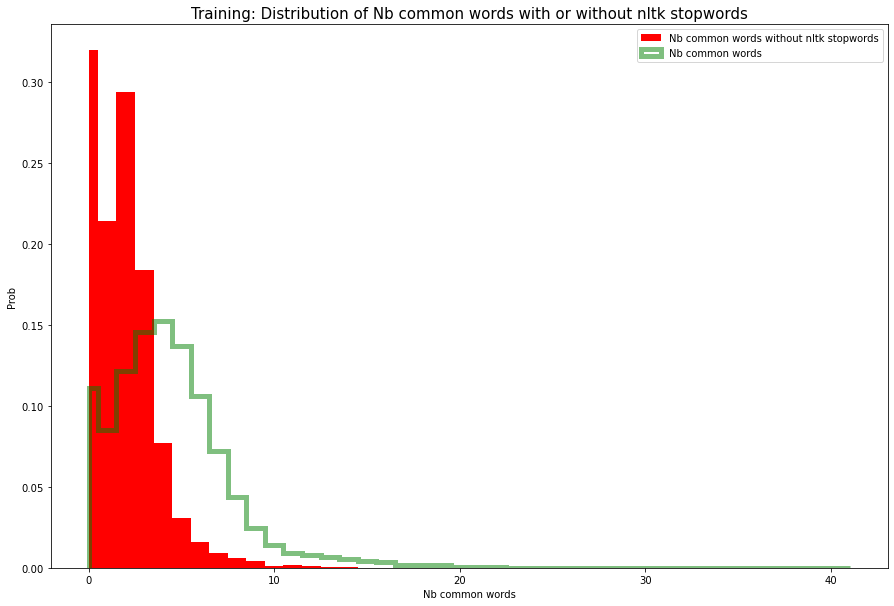

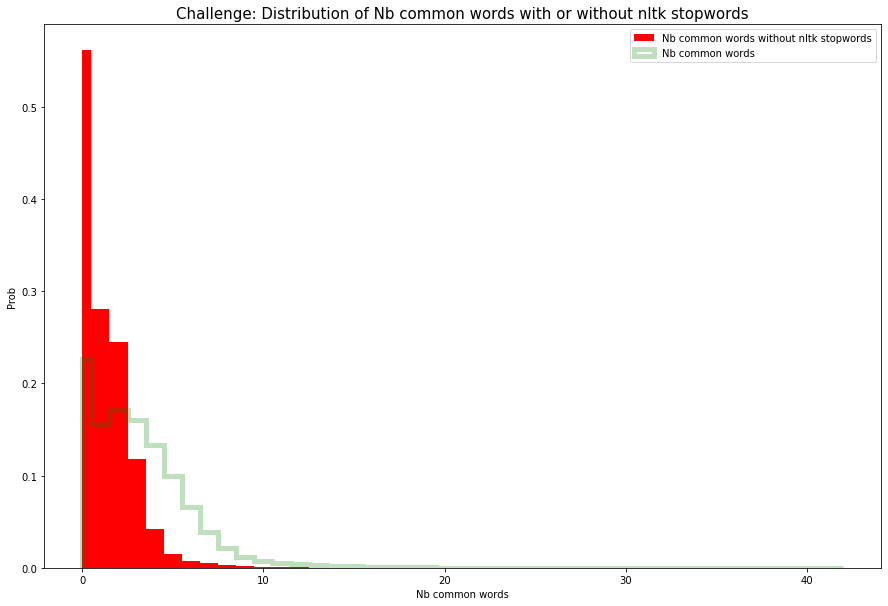

In [10]:
from astropy.visualization import hist as as_hist

#plot.figure(figsize=(15, 10))
#sns.histplot(train_dataframe['nb_common_words'],stat='count',bins=50,label='no stopwords',legend=True)
#sns.histplot(train_dataframe['nltk_nb_common_words'],stat='count',color="g",alpha=0.5,bins=50,label='nltk stopwords',legend=True)
#plot.legend()

plot.figure(figsize=(15, 10))
as_hist(train_dataframe['nltk_nb_common_words'],label="Nb common words without nltk stopwords",histtype='stepfilled',bins='blocks',density=True,color="r")
as_hist(train_dataframe['nb_common_words'],label="Nb common words",histtype='step',alpha=0.5,lw=5,bins='blocks',density=True,color="g")
plot.title('Training: Distribution of Nb common words with or without nltk stopwords', fontsize=15)
plot.xlabel('Nb common words')
plot.ylabel('Prob')
plot.legend()

plot.figure(figsize=(15, 10))
as_hist(challenge_dataframe['nltk_nb_common_words'],label="Nb common words without nltk stopwords",histtype='stepfilled',bins='blocks',density=True,color="r")
as_hist(challenge_dataframe['nb_common_words'],label="Nb common words",histtype='step',alpha=0.25,lw=5,bins='blocks',density=True,color="g")
plot.title('Challenge: Distribution of Nb common words with or without nltk stopwords', fontsize=15)
plot.xlabel('Nb common words')
plot.ylabel('Prob')
plot.legend()

### Step 4 : more stopwords
we are using also stopwords from sklearn

In [11]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


sk_stopwords = set(ENGLISH_STOP_WORDS)
print_info('There is %d words in nltk stop words' % len(nltk_stopwords))
print_info('There is %d words in sklearn stop words' % len(sk_stopwords))
new_stopwords = [w for w in sk_stopwords if w not in nltk_stopwords]
print_info('There is %d new stop words in sklearn stop words' % len(new_stopwords))

all_stop_words = nltk_stopwords | sk_stopwords
print_info('There is %d words in the union of stop words' % len(all_stop_words))

def build_all_stop_words_features(dataframe): 
    print_warning('Compute all features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: build_no_stopwords_features_one_row(r.question1,r.question2,all_stop_words))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'all_nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'all_nb_words_question2','temp',lambda x: x[7])

  
    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'all_nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'all_nb_common_words/all_nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'all_nb_common_words/all_nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'all_nb_words_question1-all_common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'all_nb_words_question2-all_common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'all_common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'all_uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'all_uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe


train_dataframe = load_or_build_dataframe('Training: Build features aware of all stopwords','training_all_stop_words_features',build_all_stop_words_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge: Build features aware of all stopwords','challenge_all_stop_words_features',build_all_stop_words_features,challenge_dataframe)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

Recap our changes : last step looks like small ...

In [12]:
nb_changed_train = int(numpy.where(train_dataframe['nltk_nb_common_words'] != train_dataframe['nb_common_words'],1,0).sum())
print_info('With nltk stop words we have changed %.2f %% of nb common_words in training!!' % (nb_changed_train*100./len(train_dataframe)))
nb_changed_train = int(numpy.where(train_dataframe['all_nb_common_words'] != train_dataframe['nb_common_words'],1,0).sum())
print_warning('Removing also sklearn stop words we have changed %.2f %% of nb common_words in training!!' % (nb_changed_train*100./len(train_dataframe)))

nb_changed_challenge = int(numpy.where(challenge_dataframe['nltk_nb_common_words']!=challenge_dataframe['nb_common_words'],1,0).sum())
print_info('With nltk stop words We have changed %.2f %% of nb common_words in challenge !!' % (nb_changed_challenge*100./len(challenge_dataframe)))
nb_changed_challenge = int(numpy.where(challenge_dataframe['all_nb_common_words']!=challenge_dataframe['nb_common_words'],1,0).sum())
print_warning('Removing also sklearn stop words we have changed %.2f %% of nb common_words in challenge !!' % (nb_changed_challenge*100./len(challenge_dataframe)))

changed = train_dataframe[train_dataframe['nltk_nb_common_words']!=train_dataframe['all_nb_common_words']]
changed[['common_words','nltk_common_words','all_common_words','uncommon_words_question1','nltk_uncommon_words_question1','all_uncommon_words_question1']].head(3)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,common_words,nltk_common_words,all_common_words,uncommon_words_question1,nltk_uncommon_words_question1,all_uncommon_words_question1
13,"{was, what, first, sexual, your}","{first, sexual}",{sexual},"{like?, experience}","{like?, experience}","{like?, experience}"
30,"{you, thing, one, better?, do, what's}","{thing, one, better?, what's}","{thing, better?, what's}","{would, like, to}","{would, like}",{like}
32,"{of, to, villain, what, most, game, be, you, thrones, the, would}","{thrones, would, game, villain}","{thrones, game, villain}","{give, mercy?, likely}","{give, mercy?, likely}","{mercy?, likely}"


&lt;matplotlib.legend.Legend at 0x7f43e7b77430&gt;

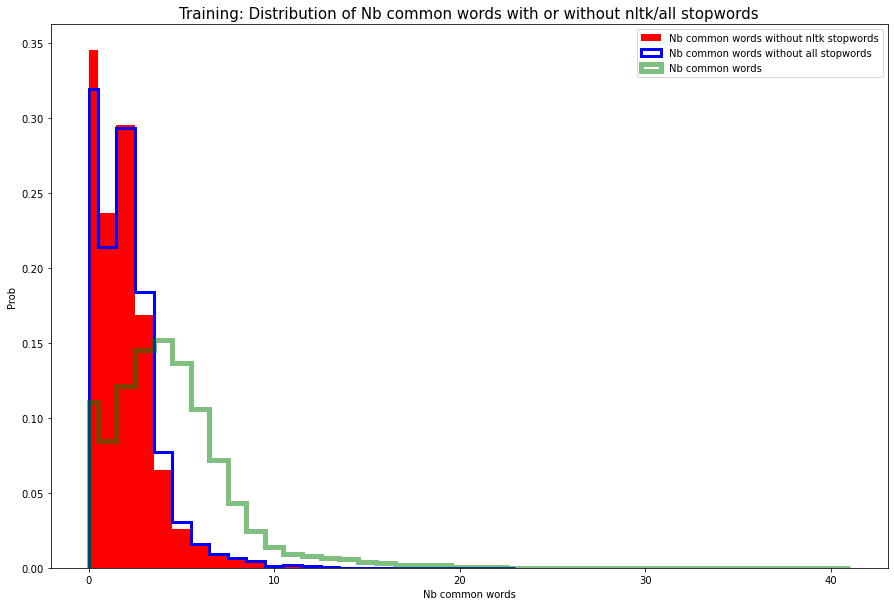

In [13]:
#plot.figure(figsize=(15, 10))
#sns.histplot(train_dataframe['nb_common_words'],stat='count',bins=50,label='no stopwords',legend=True)
#sns.histplot(train_dataframe['nltk_nb_common_words'],stat='count',color="g",alpha=0.5,bins=50,label='nltk stopwords',legend=True)
#plot.legend()

plot.figure(figsize=(15, 10))
as_hist(train_dataframe['all_nb_common_words'],label="Nb common words without nltk stopwords",histtype='stepfilled',bins='blocks',density=True,color="r")
as_hist(train_dataframe['nltk_nb_common_words'],label="Nb common words without all stopwords",histtype='step',bins='blocks',density=True,color="b",lw=3)
as_hist(train_dataframe['nb_common_words'],label="Nb common words",histtype='step',alpha=0.5,lw=5,bins='blocks',density=True,color="g")
plot.title('Training: Distribution of Nb common words with or without nltk/all stopwords', fontsize=15)
plot.xlabel('Nb common words')
plot.ylabel('Prob')
plot.legend()

### Did you get this strange % of change in challenge ??

We have changed 86.44% of common word in train data
Applying same proces, we changed only 77.67% of challenge data

Let's dig a little bit



In [14]:
challenge_dataframe[challenge_dataframe['all_nb_words_question2-all_common_words']>5].sample(1000,random_state=46)['all_uncommon_words_question1']

1070570                                                  {buy, 20, yearly, fail, 11, half}
1976751    {like, income?, things, priced, groceries, economy, percentage, based, certain}
1829157            {form, it?, use, correct, &quot;specialising&quot;, &quot;specializing&quot;?, appropriate}
1945017                                           {computer, understand, teach, argument?}
2007137                                                           {buy?, job?, tv, lg, vu}
                                                ...                                       
658568                                            {best, export, import, advice, vietnam?}
261800                       {mind, jee, things, registering, counselling, choices, main?}
1713155                                        {happens, fuel, tell, unleaded, csn, tank?}
1333987                                   {best, dinner, cream, seersucker, color, slacks}
1342031                                   {nestaway, structures, algor

### OK start to see the pbm
* all question marks at end must be removed
* some weird " in words
* maybe some typos like a digit or a punctuation in words

Let's see how are the really unknown words ie not present in english dictionary

In [15]:
from english_words import english_words_lower_alpha_set

def load_english_words():
    with open(absolute_env_file_name('../words_alpha',ext='.txt')) as word_file:
        valid_words = set(word_file.read().split())
    print_info('size of first dictionary %d' % len(valid_words))
    print_info('size of second dictionary %d' % len(english_words_lower_alpha_set))
    valid_words = valid_words | english_words_lower_alpha_set
    print_info('size of merged dictionary %d' % len(valid_words))
    return valid_words

print_info('Load a big dictionary of English words')
english_words = load_english_words()
print_info('Dictionary of english words contains %d words' % len(english_words))
print_info("Let's find unshared words that are fully alpha and not in dictionary. Candidate for typos ?")

train_dataframe['unknown_question1'] = train_dataframe['all_uncommon_words_question1'].progress_apply(lambda x: [ w for w in x if w not in english_words and not w.isalpha() ])
train_dataframe['nb_unknown_question1'] = train_dataframe['unknown_question1'].progress_apply(len)
train_dataframe['unknown_question2'] = train_dataframe['all_uncommon_words_question2'].progress_apply(lambda x: [ w for w in x if w not in english_words and not w.isalpha() ])
train_dataframe['nb_unknown_question2'] = train_dataframe['unknown_question2'].progress_apply(len)

challenge_dataframe['unknown_question1'] = challenge_dataframe['all_uncommon_words_question1'].progress_apply(lambda x: [ w for w in x if w not in english_words and not w.isalpha() ])
challenge_dataframe['nb_unknown_question1'] = challenge_dataframe['unknown_question1'].progress_apply(len)
challenge_dataframe['unknown_question2'] = challenge_dataframe['all_uncommon_words_question2'].progress_apply(lambda x: [ w for w in x if w not in english_words and not w.isalpha() ])
challenge_dataframe['nb_unknown_question2'] = challenge_dataframe['unknown_question2'].progress_apply(len)



&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

Do a Kolmogorov-Smirnow to see if distribution of unknown words is different in train and challenge

In [16]:
from scipy.stats import ks_2samp

print_section('Basic stats on len of unshared & unknown words')
print_warning('Train Nb unknown words in question 1 mean %.3f std: %3.f max %d' %(train_dataframe['nb_unknown_question1'].mean(),train_dataframe['nb_unknown_question1'].std(),train_dataframe['nb_unknown_question1'].max() ))
print_warning('%.3f %% of lines have such words' % (train_dataframe['nb_unknown_question1'].where(train_dataframe['nb_unknown_question1']>0).count()/len(train_dataframe)))
print_warning('Train Nb unknown words in question 2 mean %.3f std: %3.f max %d' %(train_dataframe['nb_unknown_question2'].mean(),train_dataframe['nb_unknown_question2'].std(),train_dataframe['nb_unknown_question1'].max() ))
print_warning('%.3f %% of lines have such words' % (train_dataframe['nb_unknown_question2'].where(train_dataframe['nb_unknown_question2']>0).count()/len(train_dataframe)))

print_warning('Challenge Nb unknown words in question 1 mean %.3f std: %3.f max %d' %(challenge_dataframe['nb_unknown_question1'].mean(),challenge_dataframe['nb_unknown_question1'].std(),challenge_dataframe['nb_unknown_question1'].max() ))
print_warning('%.3f %% of lines have such words' % (challenge_dataframe['nb_unknown_question1'].where(challenge_dataframe['nb_unknown_question1']>0).count()/len(challenge_dataframe)))
print_warning('Challenge Nb unknown words in question 2 mean %.3f std: %3.f max %d' %(challenge_dataframe['nb_unknown_question2'].mean(),challenge_dataframe['nb_unknown_question2'].std(),challenge_dataframe['nb_unknown_question1'].max() ))
print_warning('%.3f %% of lines have such words' % (challenge_dataframe['nb_unknown_question2'].where(challenge_dataframe['nb_unknown_question2']>0).count()/len(challenge_dataframe)))

print()
print_section('Using a Kolmogorov-Smirnow test')
print_info('Null hypothesis : the 2 distributions of nb unknown words in question 1 are similar')
print_warning(str(ks_2samp(train_dataframe['nb_unknown_question1'],challenge_dataframe['nb_unknown_question1'])))
print_alert('stat is small but p-value is 0: we reject null hypothesis: distributions are not similar')
print_info('Null hypothesis : the 2 distributions of nb unknown words in question 2 are similar')
print_warning(str(ks_2samp(train_dataframe['nb_unknown_question2'],challenge_dataframe['nb_unknown_question2'])))
print_alert('stat is small but p-value is 0: we reject null hypothesis: distributions are not similar')

print_alert('challenge is not using the same vocabulary as training')



&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

Maybe it's just because challenge's question are longer ?

redo it on ratio nb_unknown/nb_total

Answer still no

In [17]:
print_warning(str(ks_2samp(train_dataframe['nb_unknown_question1']/train_dataframe['all_nb_words_question1'],challenge_dataframe['nb_unknown_question1']/challenge_dataframe['all_nb_words_question1'])))


&lt;IPython.core.display.HTML object&gt;

In [18]:
# Code to keep : most efficient way of computing a complex column with tests ?
# train_dataframe['all_nb_words_question1_ratio'] = 0.0
#train_dataframe.loc[(train_dataframe['nb_words_question1']>0.),'all_nb_words_question1_ratio'] = train_dataframe['all_nb_words_question1']/train_dataframe['nb_words_question1']train_dataframe['all_nb_words_question1_ratio']


## Compute AUC of these basic features and try to figure if there is a bit of information inside each one

ie is it helping to separate 1 from 0?

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

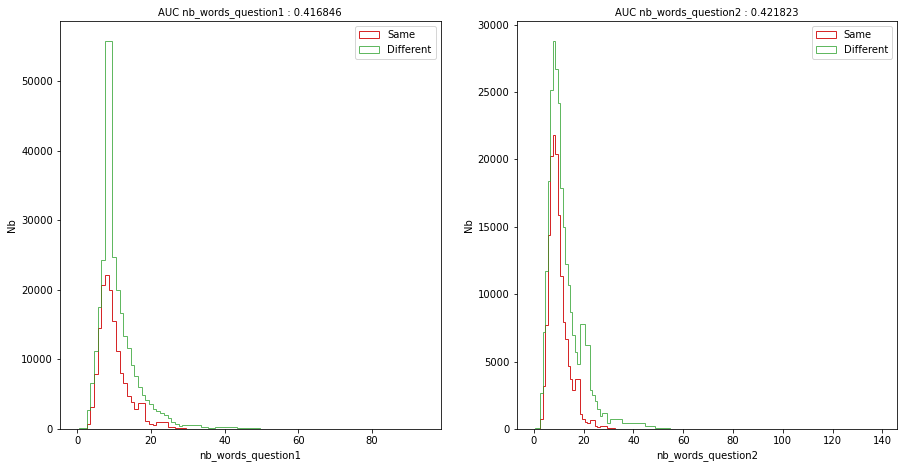

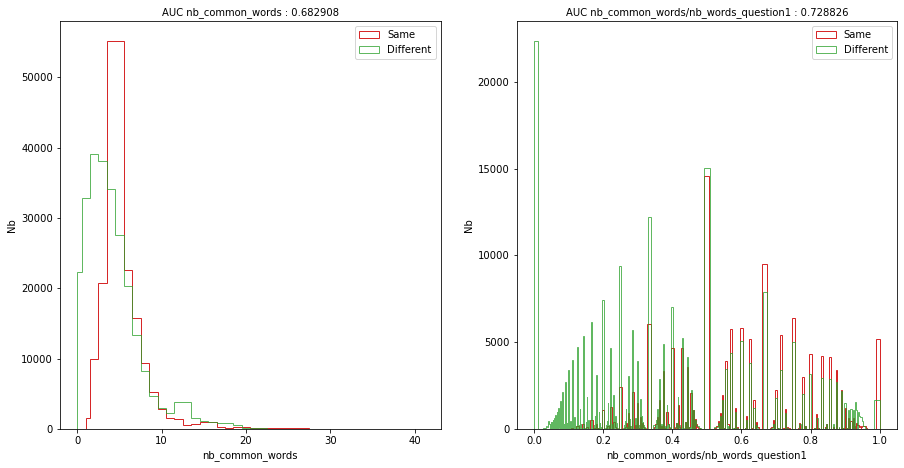

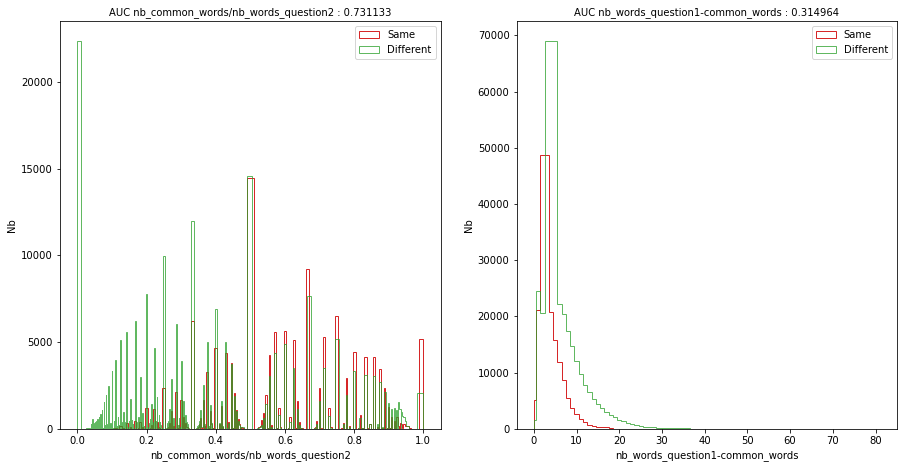

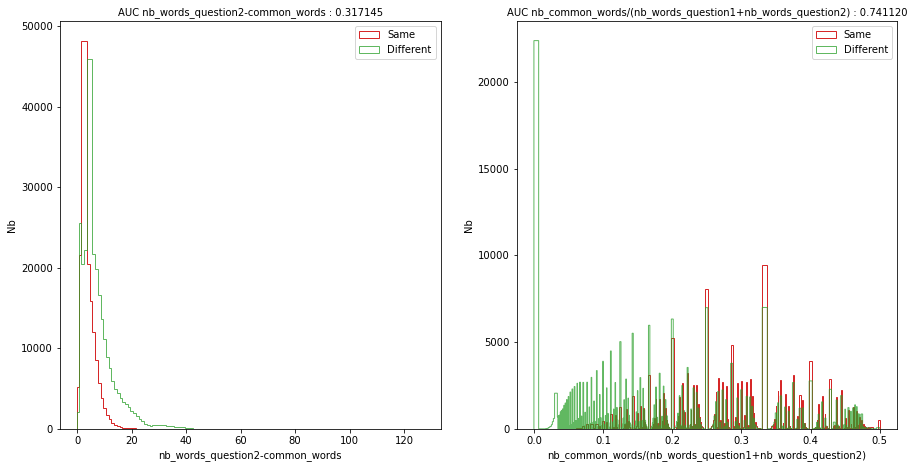

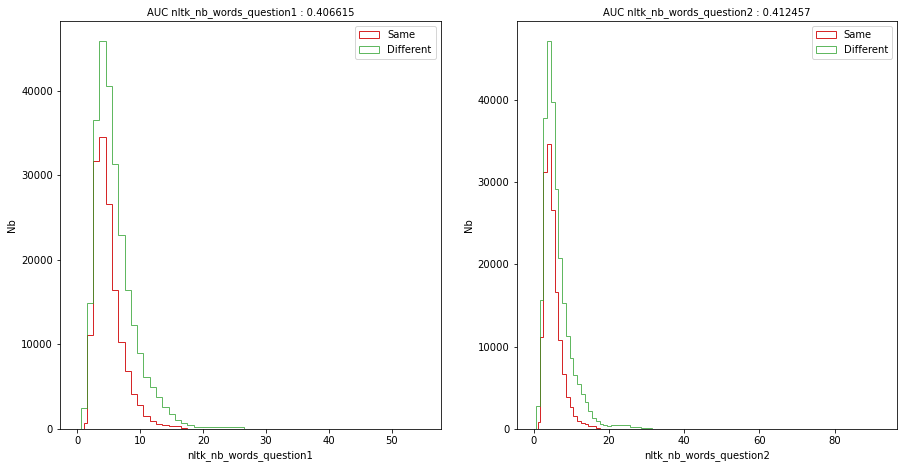

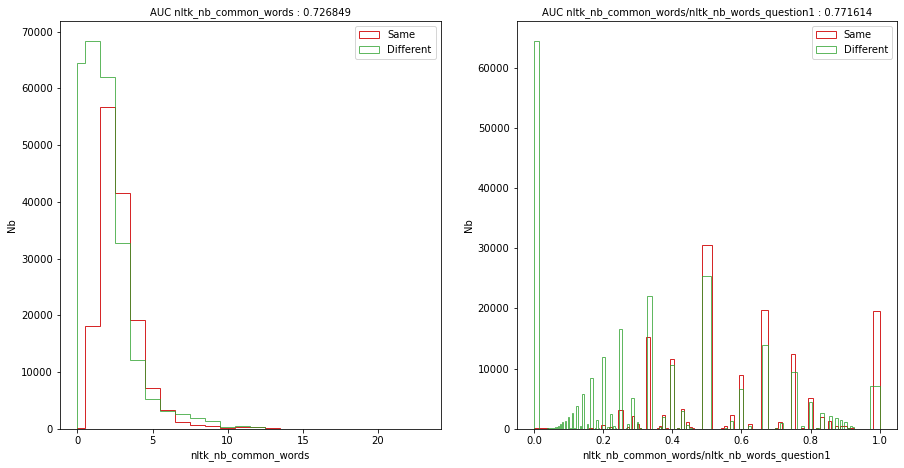

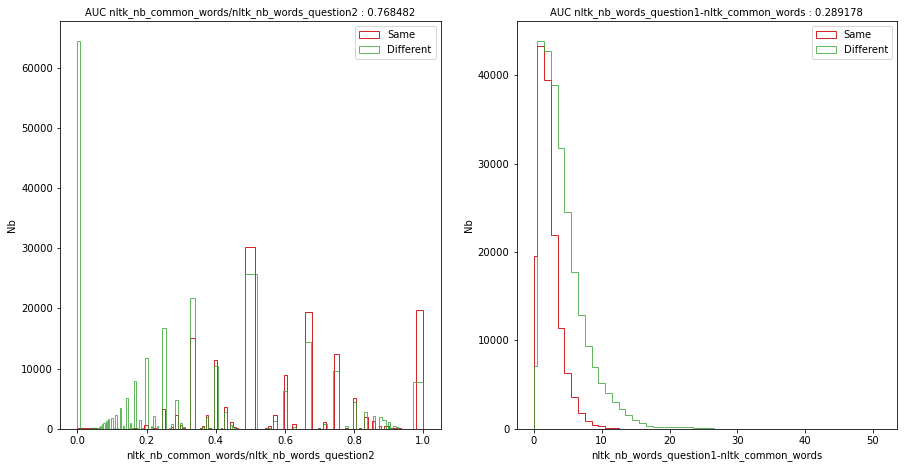

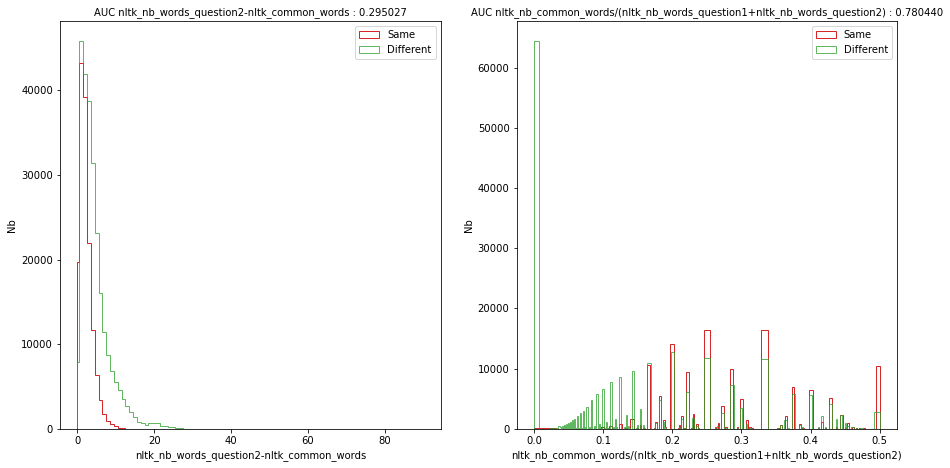

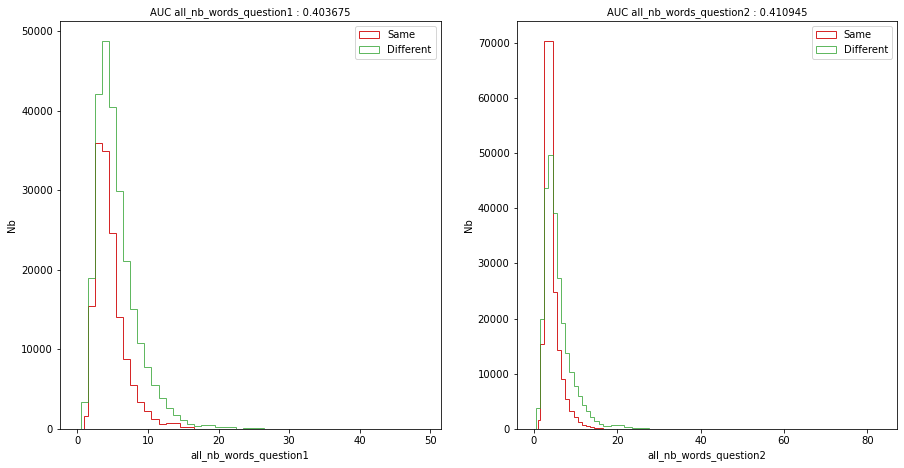

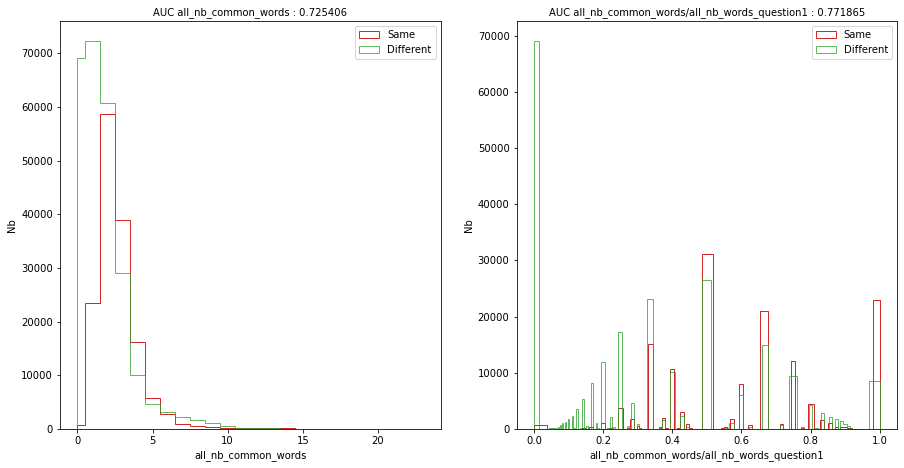

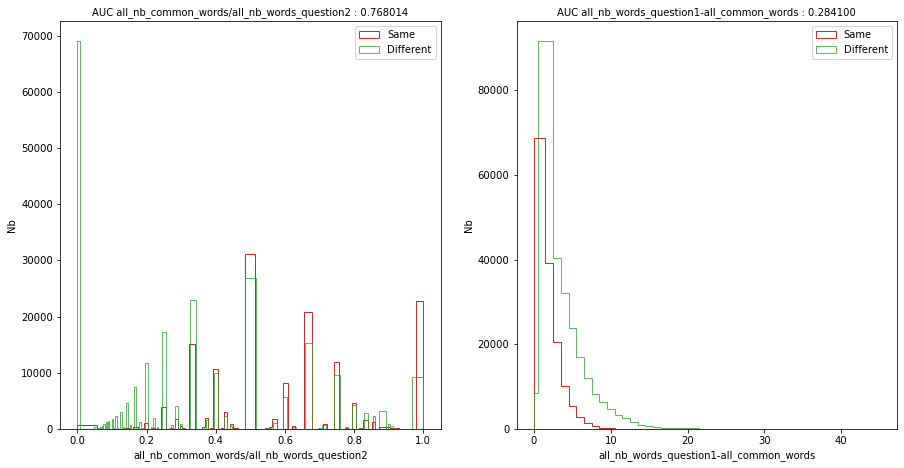

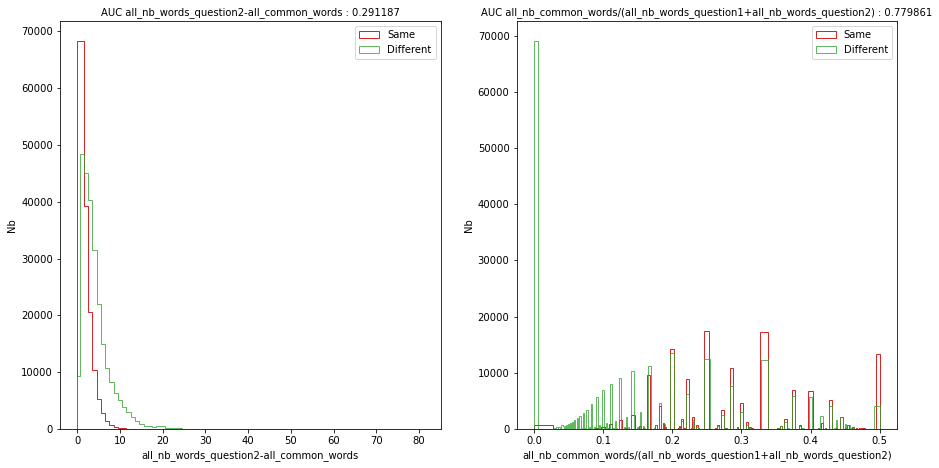

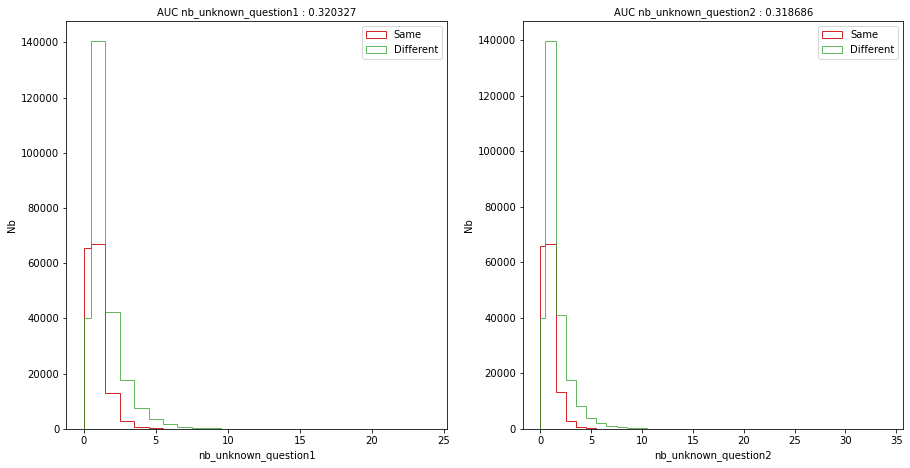

In [19]:
from sklearn.metrics import roc_auc_score

def simple_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name])

def simple_weighted_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name],sample_weight=dataframe['weight'])

def show_AUC(dataframe,column_name):
    if 'weight' in dataframe.columns:
        print_bullet('Weighted AUC %s %f' % (column_name,simple_weighted_AUC(dataframe,column_name)))
    else:
        print_bullet('AUC %s %f' % (column_name,simple_AUC(dataframe,column_name)))
        

def display_simple_AUC(dataframe,column_name):
    palette = sns.color_palette()
    # Let multiplot_generator figure the size
    #plot.figure(figsize=(10, 7))
    #plot.hist(dataframe[column_name][dataframe['is_duplicate']==1],bins=50,color=palette[3],label='Same',histtype='step')
    #plot.hist(dataframe[column_name][dataframe['is_duplicate']==0],bins=50,color=palette[2],label='Different',alpha = 0.75,histtype='step')
    as_hist(dataframe[column_name][dataframe['is_duplicate']==1],bins="blocks",color=palette[3],label='Same',histtype='step')
    as_hist(dataframe[column_name][dataframe['is_duplicate']==0],bins="blocks",color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('AUC %s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.ylabel('Nb')
    plot.legend()



def show_all_simple_AUC(dataframe):
    all =  all_numeric_columns(dataframe)
    print_section( 'Show AUC on %d unique features' % len(all))
    for name in all:
        show_AUC(dataframe,name)
        yield
        display_simple_AUC(dataframe,name)
    print_done('Done')


def show_all_simple_AUC_in_grid(dataframe,nb_columns=2):
    multiplot_from_generator(show_all_simple_AUC(dataframe), nb_columns)

show_all_simple_AUC_in_grid(train_dataframe,nb_columns=2)

## OK Visualising these AUC is cool
Can we have some numbers ?

In [20]:

from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest,f_classif,RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

def graph_relative_feature_importance(features_importances,columns):
    # Make importances relative to max importance.
    features_importances = 100.0 * (features_importances / features_importances.max())
    sorted_idx = numpy.argsort(features_importances)
    sorted_idx = sorted_idx[-20:-1:1]
    pos = numpy.arange(sorted_idx.shape[0]) + 0.5
    plot.barh(pos, features_importances[sorted_idx], align='center')
    plot.yticks(pos, columns)
    plot.xlabel('Relative Importance')
    plot.title('Relative Feature Importance', fontsize=30)
    plot.tick_params(axis='x', which='major', labelsize=15)
    sns.despine(left=True, bottom=True)
    plot.show()

def graph_feature_importance(features_importances,columns):
    # Make importances relative to max importance.
    sorted_idx = numpy.argsort(features_importances)
    sorted_idx = sorted_idx[-20:]
    pos = numpy.arange(sorted_idx.shape[0]) + 0.5
    plot.barh(pos, features_importances[sorted_idx], align='center')
    plot.yticks(pos, columns)
    plot.xlabel('Importance')
    plot.title('Feature Importance', fontsize=30)
    plot.tick_params(axis='x', which='major', labelsize=15)
    #sns.despine(left=True, bottom=True)
    plot.show()

def independant_features_analysis(name_data,input_df,target_df):
    train_df = input_df[all_numeric_columns(input_df)]
    target_df = target_df
    small = int(len(target_df)*0.05)
    small_train = train_df.sample(small,random_state=42)
    small_target = target_df.sample(small,random_state=42)
    small_weights = input_df[WEIGHT].sample(small,random_state=42)

    # be careful all_numeric will include also the target soon
    all_numeric = all_numeric_columns(input_df)
    print_section('Minimal analysis of numeric features of %s' % name_data)
    print_info('Nb features: %d' % len(all_numeric))
    print_info(str(all_numeric))
    print_warning('Is there any null value ? %s' % input_df.isnull().any().any())

    compute_variances = feature_selection.VarianceThreshold()
    all_numeric.append('is_duplicate')
    variances = compute_variances.fit_transform(input_df[all_numeric])
    print_warning('Is there any low variance feature ? %s' % str(variances.shape[1]!=len(all_numeric)))
    print_info('Here are the correlations to the target "is_duplicate"')
    correlation_matrix = input_df[all_numeric].corr().abs()
    print(correlation_matrix['is_duplicate'].nlargest(len(all_numeric)))

    correlation_matrix_without_is_duplicate = correlation_matrix['is_duplicate'][correlation_matrix['is_duplicate']<1]
    highest_correlated_feature = correlation_matrix_without_is_duplicate.nlargest(1).index[0]
    highest_correlation = correlation_matrix_without_is_duplicate.nlargest(1)[0]
    if highest_correlation >0.2:
        if highest_correlation < 0.5:
            print_warning('%s is the most correlated with target but %f is quite weak' % (highest_correlated_feature,highest_correlation))
        else:
            print_info('%s is the most correlated with target but %f is very weak' % (highest_correlated_feature,highest_correlation))
    else:
        print_alert('%s is the most correlated with target and %f is quite big' % (highest_correlated_feature,highest_correlation))
    plot.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix,annot=True,cbar=True,square=True,cmap='coolwarm',mask = numpy.triu(correlation_matrix))
    plot.show()

    # we keep only numeric features and remove is_duplicate
    all_numeric = all_numeric_columns(input_df)

    print_section('Here are the features that would be selected with a simple univariate analysis')
    start = time.time()
    for r in tqdm(range(1,len(all_numeric))):
        k_best = SelectKBest(score_func=f_classif,k=r)
        fit = k_best.fit(small_train,small_target)
        best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
        print_info('Nb features to keep %d:%s' %(r,best_columns))
        
        # Can we graph relative importances
        if r>1:
            # transform train set so we can compute importances
            univariate_features = fit.transform(small_train)
            rfc = RandomForestClassifier(n_estimators=100)
            rfc_scores = cross_val_score(rfc, univariate_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
            features_importance = rfc.fit(univariate_features, small_target).feature_importances_
            graph_relative_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)
    
    print_section('Here are the features that would be selected a priori from default Multinomial Naive Bayes')
    start = time.time()   
    mnb = MultinomialNB()
    best_from_model = feature_selection.SelectFromModel(mnb)
    fit = best_from_model.fit(small_train,small_target,sample_weight=small_weights)
    print(fit.get_support(indices=True))
    best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
    # transform train set so we can compute importances
    mnb_features = fit.transform(small_train)
    rfc = RandomForestClassifier(n_estimators=100)
    rfc_scores = cross_val_score(rfc, mnb_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
    features_importance = rfc.fit(mnb_features, small_target).feature_importances_
    print(features_importance)
    print_info('features to keep :%s logloss %.4f %.4f' %(best_columns,-rfc_scores.mean(),rfc_scores.std()))
    graph_relative_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)
    

    print_info('Try to keep x \% of variance with a PCA')
    print_alert('bug ?')
    start = time.time()
    for r in tqdm([.8,.9,.95]):
        acp = PCA(r)
        principal_components = acp.fit_transform(small_train)
        principal_df = pandas.DataFrame(principal_components).sample(small,random_state=42)
        rfc = RandomForestClassifier(n_estimators=100)
        rfc_scores = cross_val_score(rfc, principal_df, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
        features_importance = rfc.fit(principal_df, small_target).feature_importances_
        print_info('%% of variance %f:%s' %(r,'aie'))
        graph_relative_feature_importance(features_importance,small_train.columns)
    print_done('Done',top=start)

    print_section('Here are the features that would be selected with a recursive feature elimination')
    start = time.time()
    print_alert('Doomed to fail : RFE does not support to transmit ,sample_weight=small_weights')
    print_alert('ix is waiting since 2016 ?')
    for r in tqdm(range(1,len(all_numeric))):
        mnb = MultinomialNB()
        recursive_best= feature_selection.RFE(mnb, n_features_to_select=r)
        fit = recursive_best.fit(small_train,small_target)
        best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
        print_info('Nb features to keep %d:%s' %(r,best_columns))
        
        # Can we graph relative importances
        if r>1:
            # transform train set so we can compute importances
            recursive_features = fit.transform(small_train)
            rfc = RandomForestClassifier(n_estimators=100)
            rfc_scores = cross_val_score(rfc, recursive_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
            features_importance = rfc.fit(recursive_features, small_target).feature_importances_
            graph_relative_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)
   

# !!!!! a little bit long
#independant_features_analysis('train',train_dataframe,train_dataframe['is_duplicate'])



## Previous exploration of all combination of features was not very successfull and very heavy
### Let's try another strategy : on a given 'theme' of fields, add each field one by one to a model

Some code to wrap XGBoost

In [21]:
# Simple XGBoost code
# 

import xgboost 

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta' : 0.02,
    'max_depth':3 
    }



def print_res_xgboost(infos):
    # Glurk
    print_info(' | '.join([('%s '+f) % (k,infos[k]) for k,f in INFO_XGBOOST_MODEL.items() if k in infos]))

# 80% training 20% validation
def build_XGBoost_model_80_20(training,target,column_names,show=True):
    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT],nthread = -1)
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT])
    watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params,train_dm,400,watchlist,early_stopping_rounds=50,verbose_eval=verbose)
    infos = compute_metrics_model_xgboost(model,final_input_test,target_test,sample_weight = input_test[WEIGHT],show=show)
    duration = time.time()-start
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

# Pushing the limits :100 % training no validation !!
def build_XGBoost_model_100_0(training,target,column_names,show=True):
    final_train = training[list(column_names)]
    final_target = target
    final_weight = training[WEIGHT]

    train_dm = xgboost.DMatrix(final_train, label = final_target, weight = final_weight,nthread = -1)
    watchlist = [(train_dm, 'train')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params,train_dm,400,watchlist,early_stopping_rounds=50,verbose_eval=verbose)
    duration = time.time()-start
    infos = compute_metrics_model_xgboost(model,final_train,final_target,sample_weight = final_weight,show=show)
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

def compute_metrics_model_xgboost(model,input_df,target_df,sample_weight = None,show = True):
    final_input = xgboost.DMatrix(input_df)
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    # Hum shouldn't we challenge this 50% threshold ?
    prediction_df = numpy.where(prediction_proba_df>0.5,1,0)
    res = metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight = sample_weight)
    if show:
        print_info('Classification report')
        print(metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight))
    return {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           }

INFO_XGBOOST_MODEL= {
    'logloss_proba': '%.4f',
    'score': '%.4f',
    'accuracy': '%.4f',
    'time': '%.2f'
}

print_res_xgboost({'alain':1})

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 100_0')
    res = build_XGBoost_model_100_0(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 80_20')
    res = build_XGBoost_model_80_20(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

[0]	train-logloss:0.68219
Will train until train-logloss hasn&#39;t improved in 50 rounds.
[10]	train-logloss:0.59191
[20]	train-logloss:0.52711
[30]	train-logloss:0.47893
[40]	train-logloss:0.44252
[50]	train-logloss:0.41449
[60]	train-logloss:0.39271
[70]	train-logloss:0.37534
[80]	train-logloss:0.36116
[90]	train-logloss:0.34963
[100]	train-logloss:0.34000
[110]	train-logloss:0.33185
[120]	train-logloss:0.32520
[130]	train-logloss:0.31990
[140]	train-logloss:0.31532
[150]	train-logloss:0.31117
[160]	train-logloss:0.30752
[170]	train-logloss:0.30422
[180]	train-logloss:0.30155
[190]	train-logloss:0.29900
[200]	train-logloss:0.29674
[210]	train-logloss:0.29478
[220]	train-logloss:0.29273
[230]	train-logloss:0.29079
[240]	train-logloss:0.28912
[250]	train-logloss:0.28763
[260]	train-logloss:0.28609
[270]	train-logloss:0.28420
[280]	train-logloss:0.28242
[290]	train-logloss:0.28097
[300]	train-logloss:0.27954
[310]	train-logloss:0.27828
[320]	train-logloss:0.27679
[330]	train-logloss:0.

&lt;IPython.core.display.HTML object&gt;

              precision    recall  f1-score   support

           0       0.87      0.98      0.93 833.5098453967706
           1       0.80      0.31      0.45 171.66892895091271

    accuracy                           0.87 1005.1787743476833
   macro avg       0.84      0.65      0.69 1005.1787743476833
weighted avg       0.86      0.87      0.84 1005.1787743476833



&lt;IPython.core.display.HTML object&gt;

{&#39;accuracy&#39;: 0.8688918455470083, &#39;score&#39;: 0.8436725569118156, &#39;logloss_proba&#39;: 0.26544821263475227, &#39;model&#39;: &lt;xgboost.core.Booster object at 0x7f419e4d0d90&gt;, &#39;time&#39;: 1.2331733703613281}


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

[0]	train-logloss:0.68248	valid-logloss:0.68185
Multiple eval metrics have been passed: &#39;valid-logloss&#39; will be used for early stopping.

Will train until valid-logloss hasn&#39;t improved in 50 rounds.
[10]	train-logloss:0.59396	valid-logloss:0.58720
[20]	train-logloss:0.53078	valid-logloss:0.51962
[30]	train-logloss:0.48387	valid-logloss:0.47019
[40]	train-logloss:0.44798	valid-logloss:0.43219
[50]	train-logloss:0.42040	valid-logloss:0.40335
[60]	train-logloss:0.39861	valid-logloss:0.38074
[70]	train-logloss:0.38136	valid-logloss:0.36279
[80]	train-logloss:0.36768	valid-logloss:0.34926
[90]	train-logloss:0.35697	valid-logloss:0.33940
[100]	train-logloss:0.34797	valid-logloss:0.33182
[110]	train-logloss:0.34059	valid-logloss:0.32623
[120]	train-logloss:0.33448	valid-logloss:0.32156
[130]	train-logloss:0.32924	valid-logloss:0.31775
[140]	train-logloss:0.32480	valid-logloss:0.31426
[150]	train-logloss:0.32054	valid-logloss:0.31102
[160]	train-logloss:0.31729	valid-logloss:0.3086

&lt;IPython.core.display.HTML object&gt;

              precision    recall  f1-score   support

           0       0.87      0.98      0.92 168.7955573880411
           1       0.71      0.28      0.40 33.5771183347514

    accuracy                           0.86 202.37267572279248
   macro avg       0.79      0.63      0.66 202.37267572279248
weighted avg       0.84      0.86      0.84 202.37267572279248



&lt;IPython.core.display.HTML object&gt;

{&#39;accuracy&#39;: 0.8614227285353984, &#39;score&#39;: 0.8355391178278425, &#39;logloss_proba&#39;: 0.29117318050175395, &#39;model&#39;: &lt;xgboost.core.Booster object at 0x7f419e4ec580&gt;, &#39;time&#39;: 0.3865315914154053}


Some code to do some campaign and browse results

In [22]:
def find_best_result(results,metric):
    if 'logloss' in metric:
        return results.nsmallest(1,metric)
    else:
        return results.nlargest(1,metric)
        
def apply_xgboost(model,columns,input_df):
    res = pandas.DataFrame()
    res['test_id'] = input_df['test_id']
    res['is_duplicate'] = model.predict(xgboost.DMatrix(input_df[columns]))
    return res

def submit_best_result(results,input_df,file_name,kaggle_message,metric='logloss_proba'):
    start = time.time()
    print_section("Scoring XGBoost model with best %s: %s" % (metric,kaggle_message))
    csv_file_name = absolute_env_file_name(file_name,ext='.csv')
    print_info('Generating scores in %s' % csv_file_name)
    best = find_best_result(results,metric)
    model = best['model'][0]
    columns = best['columns'][0]
    prediction = apply_xgboost(model,columns,input_df)
    prediction.to_csv(csv_file_name,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(csv_file_name)
    print_done('Done',top=start)
    print_info('%s is ready' % absolute_file_name_zip)
    print_warning('Use this commands to submit apply results to kaggle')
    print_warning('kaggle competitions submit quora-question-pairs -f "%s" -m "%s %s"' % (absolute_file_name_zip,EXPERIMENT,kaggle_message))
    return prediction

def n_columns(columns,n):
    return columns[0:n]

def xgboost_all_fields_80_20(dataframe,columns_to_explore,explore=True):
    if explore:
        print_section("XGBoost (80,20) on 1 to %d fields" % len(columns_to_explore))
    else:
        print_section("XGBoost (80,20) on %d fields" % len(columns_to_explore))
    start = time.time()
    res_final = dict()
    min_log_loss = 1000
    best = 0
    best_cols =''
    # a shortcut is possible
    if explore:
        first_nb = 1
    else:
        first_nb=len(columns_to_explore)
    for i in tqdm(range(first_nb,len(columns_to_explore)+1)):
        columns = n_columns(columns_to_explore,i)
        res = build_XGBoost_model_80_20(dataframe,dataframe['is_duplicate'],columns,show = False)
        cur_logloss = res['logloss_proba']
        if cur_logloss<min_log_loss:
            print_info("%d:%.4f %s" % (i,cur_logloss,columns))
            min_log_loss = cur_logloss
            best_cols = columns
            best = i
        else:
            print_warning("%d:%.4f" % (i,cur_logloss))
        res.update( {'columns':columns})
        res_final.update({str(i):res})
    print_info('Best: %d %.4f %s' % (best,min_log_loss,best_cols))
    print_done('Done',top=start)
    return pandas.DataFrame.from_dict(res_final, orient='index')

# try to reload from cache an exploration
# if not available, redo it and save results in cache
# find the best result according to a metric (default logloss_proba)
# and submit it to kaggle
def study_fields(message,tag,columns,train_df,challenge_df,explore=True):
    print_section(message)
    results = load_or_build_dataframe('Rebuild XGBoost models',tag + '_results',lambda df:xgboost_all_fields_80_20(df,columns,explore=explore),train_df)
    save_models_dict_to_excel(results,tag=tag)
    display(results.describe())
    submit_best_result(results,challenge_df,'Best_'+tag,'Best ' + tag)
    return results


### Let's start our exploration with XGBoost (basic setup)

Let's define our 'domains'
* All features without any preprocessing except lowercasing
* All features aware of nltk list of stop words
* All features aware of extended list of stop words
* All 'not in english dictionary'
* All features except dict ones
* All features


In [23]:
# ALL_STOP_COLUMNS= ['no_stopword_nb_common_words', 'no_stopword_nb_common_words/(no_stopword_nb_words_question1+no_stopword_nb_words_question2)',       'no_stopword_nb_common_words/no_stopword_nb_words_question1', 'no_stopword_nb_common_words/no_stopword_nb_words_question2', 'no_stopword_nb_words_question1',       'no_stopword_nb_words_question1-no_stopword_common_words', 'no_stopword_nb_words_question2', 'no_stopword_nb_words_question2-no_stopword_common_words']

# ALL_NO_STOP_COLUMNS= ['no_stopword_nb_common_words', 'no_stopword_nb_common_words/(no_stopword_nb_words_question1+no_stopword_nb_words_question2)',       'no_stopword_nb_common_words/no_stopword_nb_words_question1', 'no_stopword_nb_common_words/no_stopword_nb_words_question2', 'no_stopword_nb_words_question1',       'no_stopword_nb_words_question1-no_stopword_common_words', 'no_stopword_nb_words_question2', 'no_stopword_nb_words_question2-no_stopword_common_words']

# ALL_COLUMNS =[ 'nb_words_question1', 'nb_words_question2', 'nb_common_words', 'nb_common_words/nb_words_question1','nb_common_words/nb_words_question2', 'nb_words_question1-common_words', 'nb_words_question2-common_words', 'nb_common_words/(nb_words_question1+nb_words_question2)', no_stopword_nb_words_question1', 'no_stopword_nb_words_question2', 'no_stopword_nb_common_words', 'no_stopword_nb_common_words/no_stopword_nb_words_question1',       'no_stopword_nb_common_words/no_stopword_nb_words_question2', 'no_stopword_nb_words_question1-no_stopword_common_words', no_stopword_nb_words_question2-no_stopword_common_words','no_stopword_nb_common_words/(no_stopword_nb_words_question1+no_stopword_nb_words_question2)']

# To build a model with every kind of features except the 2 'not in english dict' ones
ALL_FEATURES_EXCEPT_DICT = [c for c in all_numeric_columns(train_dataframe) if 'unknown' not in c] 
# To build a model with only features not aware of any stop words
ALL_BASIC_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'nltk' not in c and 'all' not in c and 'unknown' not in c] 
# To build a model with only features aware of nltk stop words
ALL_NLTK_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'nltk' in c] 
# To build a model with only features not aware of extended stop words
ALL_EXTENDED_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'all' in c] 
# The 2 nb 'not in english dictionary' features 
ALL_DICT_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'unknown' in c] 

# everything
ALL_ALL_FEATURES = all_numeric_columns(train_dataframe)

print_section('All "not in dict" features')
print_info('Nb features %d' % len(ALL_DICT_FEATURES))
display(pandas.DataFrame(ALL_DICT_FEATURES,columns=['feature']))

print_section('All basic features')
print_info('Nb features %d' % len(ALL_BASIC_FEATURES))
display(pandas.DataFrame(ALL_BASIC_FEATURES,columns=['feature']))

print_section('All nltk features')
print_info('Nb features %d' % len(ALL_NLTK_FEATURES))
display(pandas.DataFrame(ALL_NLTK_FEATURES,columns=['feature']))

print_section('All extended features')
print_info('Nb features %d' % len(ALL_EXTENDED_FEATURES))
display(pandas.DataFrame(ALL_EXTENDED_FEATURES,columns=['feature']))

print_section('All features except "not in dict" ones')
print_info('Nb features %d' % len(ALL_FEATURES_EXCEPT_DICT))
display(pandas.DataFrame(ALL_FEATURES_EXCEPT_DICT,columns=['feature']))

print_section('All features')
print_info('Nb features %d' % len(ALL_ALL_FEATURES))
display(pandas.DataFrame(ALL_ALL_FEATURES,columns=['feature']))



&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,feature
0,nb_unknown_question1
1,nb_unknown_question2


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,feature
0,nb_words_question1
1,nb_words_question2
2,nb_common_words
3,nb_common_words/nb_words_question1
4,nb_common_words/nb_words_question2
5,nb_words_question1-common_words
6,nb_words_question2-common_words
7,nb_common_words/(nb_words_question1+nb_words_question2)


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,feature
0,nltk_nb_words_question1
1,nltk_nb_words_question2
2,nltk_nb_common_words
3,nltk_nb_common_words/nltk_nb_words_question1
4,nltk_nb_common_words/nltk_nb_words_question2
5,nltk_nb_words_question1-nltk_common_words
6,nltk_nb_words_question2-nltk_common_words
7,nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,feature
0,all_nb_words_question1
1,all_nb_words_question2
2,all_nb_common_words
3,all_nb_common_words/all_nb_words_question1
4,all_nb_common_words/all_nb_words_question2
5,all_nb_words_question1-all_common_words
6,all_nb_words_question2-all_common_words
7,all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,feature
0,nb_words_question1
1,nb_words_question2
2,nb_common_words
3,nb_common_words/nb_words_question1
4,nb_common_words/nb_words_question2
5,nb_words_question1-common_words
6,nb_words_question2-common_words
7,nb_common_words/(nb_words_question1+nb_words_question2)
8,nltk_nb_words_question1
9,nltk_nb_words_question2


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,feature
0,nb_words_question1
1,nb_words_question2
2,nb_common_words
3,nb_common_words/nb_words_question1
4,nb_common_words/nb_words_question2
5,nb_words_question1-common_words
6,nb_words_question2-common_words
7,nb_common_words/(nb_words_question1+nb_words_question2)
8,nltk_nb_words_question1
9,nltk_nb_words_question2


Basic features : no preprocessing

In [24]:
xgboost_only_stop_columns_results = study_fields(
    'Only on features not aware of any stop words',
    'basic_features_xgboost',
    ALL_BASIC_FEATURES,
    train_dataframe,
    challenge_dataframe)
 

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,8.000000,8.000000,8.000000,8.000000
mean,0.824269,0.748411,0.397414,13.849410
std,0.000358,0.003473,0.032088,1.768803
min,0.823848,0.744278,0.378417,11.950912
25%,0.823848,0.744278,0.378834,12.577541
50%,0.824451,0.750260,0.379679,13.272582
75%,0.824483,0.750759,0.400316,14.820940
max,0.824715,0.751890,0.454578,16.648975


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

Same features but nltk stop words are removed

In [25]:

xgboost_only_stop_columns_results = study_fields(
    'Only on features aware of nltk stop words',
    'nltk_features_xgboost',
    ALL_NLTK_FEATURES,
    train_dataframe,
    challenge_dataframe)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,8.000000,8.000000,8.000000,8.000000
mean,0.826876,0.758833,0.373696,13.812414
std,0.001912,0.009247,0.046502,2.462635
min,0.823848,0.744278,0.345289,9.889084
25%,0.826177,0.755126,0.346529,12.981684
50%,0.827944,0.763943,0.348628,13.132799
75%,0.828081,0.764509,0.378222,14.608162
max,0.828257,0.766459,0.454522,18.033993


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

Same features but extended list of stop words are removed

In [26]:
xgboost_only_stop_columns_results = study_fields(
    'Only on features aware of extended stop words',
    'extended_features_xgboost',
    ALL_EXTENDED_FEATURES,
    train_dataframe,
    challenge_dataframe)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,8.000000,8.000000,8.000000,8.000000
mean,0.826351,0.759590,0.378298,14.613474
std,0.001596,0.009657,0.043924,2.032736
min,0.823848,0.744278,0.352228,10.904184
25%,0.825725,0.756166,0.353006,13.732400
50%,0.827082,0.765070,0.354311,14.616342
75%,0.827512,0.765480,0.381855,15.618328
max,0.827565,0.766911,0.454718,17.564442


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

All features except the 'not in english dictionary ones'

In [27]:
xgboost_only_stop_columns_results = study_fields(
    'All features excepr not in dict ones',
    'all_no_dict_features_xgboost',
    ALL_FEATURES_EXCEPT_DICT,
    train_dataframe,
    challenge_dataframe)  

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,24.000000,24.000000,24.000000,24.000000
mean,0.826767,0.758168,0.363050,21.050462
std,0.002300,0.009068,0.032227,7.086816
min,0.823848,0.744278,0.339034,11.714211
25%,0.824504,0.750045,0.339719,15.340022
50%,0.828179,0.765173,0.343748,20.005081
75%,0.829031,0.765633,0.378718,24.711598
max,0.829188,0.767437,0.454578,40.454157


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

All features

In [28]:

# No need to explore build directly the biggest one
xgboost_only_stop_columns_results = study_fields(
    'All features except not in dict ones',
    'all_features_xgboost',
    ALL_ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore=False) 

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,1.000000,1.000000,1.000000,1.00000
mean,0.829031,0.767318,0.336979,36.51603
std,NaN,NaN,NaN,NaN
min,0.829031,0.767318,0.336979,36.51603
25%,0.829031,0.767318,0.336979,36.51603
50%,0.829031,0.767318,0.336979,36.51603
75%,0.829031,0.767318,0.336979,36.51603
max,0.829031,0.767318,0.336979,36.51603


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

## What are our results

In [29]:
all_submissions = load_kaggle_submissions()


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

In [30]:
display(get_last_submissions(all_submissions))
display(get_best_submissions(all_submissions,10))

&lt;IPython.core.display.HTML object&gt;

,date,publicScore,privateScore,description,fileName
0,2020-10-05 22:23:29,0.33712,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
2,2020-10-05 20:25:43,0.34084,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip
3,2020-10-05 20:05:27,0.33884,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip


&lt;IPython.core.display.HTML object&gt;

,publicScore,date,privateScore,description,fileName
0,0.33712,2020-10-05 22:23:29,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
3,0.33884,2020-10-05 20:05:27,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip
2,0.34084,2020-10-05 20:25:43,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip
7,0.34351,2020-10-03 14:03:04,0.34530,clean_data Best clean_all_features_xgboost,Best_clean_all_features_xgboost.zip
10,0.34351,2020-10-03 10:22:13,0.34530,clean_data Best clean_all_features_xgboost,Best_clean_all_features_xgboost.zip
8,0.34354,2020-10-03 11:23:51,0.34532,clean_data Best clean_all_features_xgboost,Best_clean_all_features_xgboost.zip
12,0.34385,2020-10-02 23:52:57,0.34564,clean_data Best clean_all_features_xgboost,Best_clean_all_features_xgboost.zip
14,0.34465,2020-10-02 13:15:55,0.34656,clean_data Best all_features_xgboost,Best_all_features_xgboost.zip
19,0.34465,2020-10-02 13:01:55,0.34656,clean_data Best all_features_xgboost,Best_all_features_xgboost.zip
15,0.34676,2020-10-02 13:15:23,0.34876,clean_data Best all_no_dict_features_xgboost,Best_all_no_dict_features_xgboost.zip


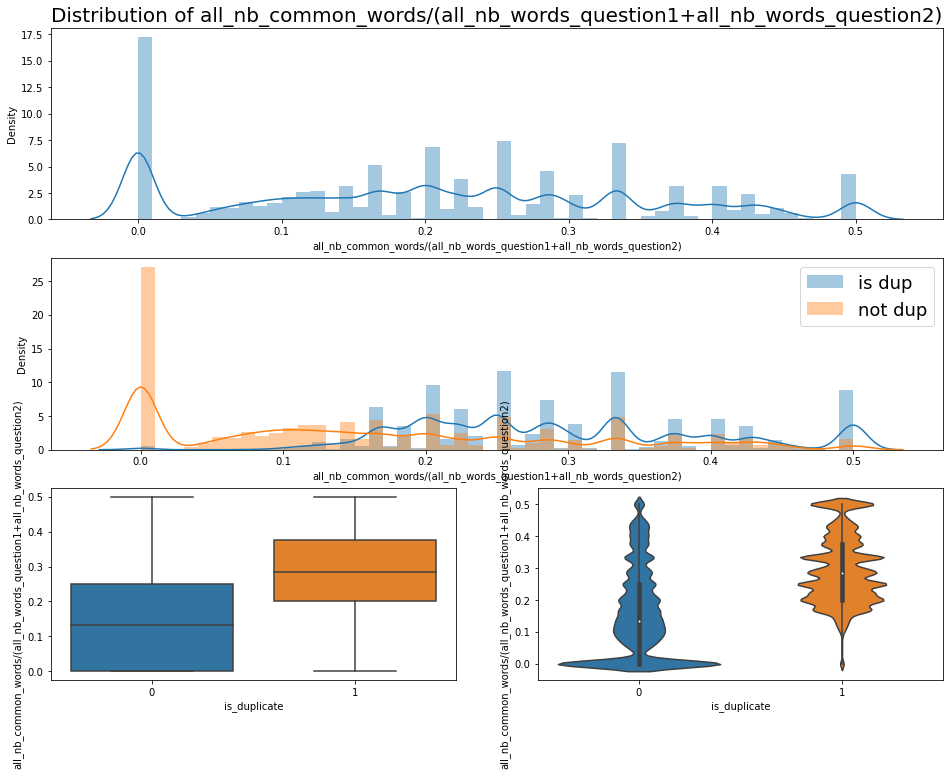

In [31]:
def plot_real_feature_density(df, fname):
    
    ix_train = numpy.where(df['id'] >= 0)[0]
    ix_test = numpy.where(df['id'] == -1)[0]
    ix_is_dup = numpy.where(df['is_duplicate'] == 1)[0]
    ix_not_dup = numpy.where(df['is_duplicate'] == 0)[0]

    fig = plot.figure(figsize=(16, 12))
    ax1 = plot.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plot.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plot.subplot2grid((3, 2), (2, 0))
    ax4 = plot.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(df.loc[ix_train][fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(df.loc[ix_is_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='is dup')    
    sns.distplot(df.loc[ix_not_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='not dup')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, 
                x='is_duplicate', 
                data=df.loc[ix_train], 
                ax=ax3)
    sns.violinplot(y=fname, 
                   x='is_duplicate', 
                   data=df.loc[ix_train], 
                   ax=ax4)
    plot.show()


plot_real_feature_density(train_dataframe,'all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)')


So, features around common words are quite good
Therefore, anything that can help to better detect common words is good

The notebook spacy_preprocessing.ipynb provides us a good preprocessing code to apply to questions before any work

We have 2 choices with this code
* generate a new domain : clean_xxxx, kepp previous domains and train a model
* restart from scratch and generate all previous domains on the new clean text


Let's start with way 1 : just add a new domain

In [32]:
# here is the code to preprocess questions
import re

# I do special stuff with $ and roupie char
FINAL_PUNC_CLEANER = str.maketrans(dict([ (c,' ') for c in '!"#%&\'()*+,./:;<=>?[\\]^_`{|}~-@']))

def clean_string(str):
    str = re.sub('\?',' ',str) # ?
    # odd chars
    # will generate more ' so do it first
    str = re.sub("’", "'", str) # special single quote
    str = re.sub("`", "'", str) # special single quote
    str = re.sub("“", '"', str) # special double quote
    str = re.sub("？", "?", str) 
    str = re.sub("…", " ", str) 
    str = re.sub("é", "e", str)
    
    # shortcuts
    str = re.sub('\'s', ' is', str) 
    str = re.sub(' whats ', ' what is ', str)
    str = re.sub('\'ve', ' have ', str)
    str = re.sub("can't", 'can not', str)
    # this one is tricky do it in order
    str = re.sub("wouldn't", 'would not', str)
    str = re.sub("n't", ' not ', str)
    str = re.sub("i'm", 'i am', str)
    str = re.sub('\'re', ' are ', str)
    str = re.sub('\'d', ' would ', str)
    str = re.sub('\'ll', ' will ', str)
    str = re.sub('e\.g\.', ' eg ', str)
    str = re.sub('b\.g\.', ' bg ', str)
    str = re.sub('e-mail', ' email ', str)
    str = re.sub('\(s\)', ' ', str)

    # Numbers and measures are a true mess
    # 12,000 -> 12000
    str = re.sub('(?<=[0-9])\,(?=[0-9])', '', str)

    # Quora is very used in India so roupie (rs) is often present
    str = re.sub("(?<=[0-9])rs ", " rs ", str)
    str = re.sub(" rs(?=[0-9])", " rs ", str)

    # stolen at kaggle : https://www.kaggle.com/currie32/the-importance-of-cleaning-str

#    str = re.sub('[c-fC-F]\:\/', ' disk ', str)
#    str = re.sub('(\d+)(kK)', ' \g<1>000 ', str)
    # very weird !!! these ones decrease the hit % WTF ?

    #str = re.sub(r" (the[\s]+|the[\s]+)?us(a)? ", " usa ", str)
    #str = re.sub('(the[\s]+|the[\s]+)?united state(s)?', ' usa ', str)

    str = re.sub(r" uk ", " england ", str)
    str = re.sub(r" imrovement ", " improvement ", str)
    str = re.sub(r" intially ", " initially ", str)
    str = re.sub(r" dms ", " direct messages ", str)  
    str = re.sub(r" demonitization ", " demonetization ", str) 
    str = re.sub(r" actived ", " active ", str)
    str = re.sub(r" kms ", " kilometers ", str)
    str = re.sub(r" cs ", " computer science ", str) 
    str = re.sub(r" upvote", " up vote", str)
    str = re.sub(r" iphone ", " phone ", str)
    str = re.sub(r" \0rs ", " rs ", str)
    str = re.sub(r" calender ", " calendar ", str)
    str = re.sub(r" ios ", " operating system ", str)
    str = re.sub(r" programing ", " programming ", str)
    str = re.sub(r" bestfriend ", " best friend ", str)
    str = re.sub(r" iii ", " 3 ", str)
    str = re.sub(r" banglore ", " bangalore ", str)
    str = re.sub(r" j k ", " jk ", str)
    str = re.sub(r" J\.K\. ", " jk ", str)

    
    # some others
    str = re.sub(r"60k", " 60000 ", str)
    str = re.sub(r" e g ", " eg ", str)
    str = re.sub(r" b g ", " bg ", str)
    str = re.sub(r"\0s", "0", str)
    str = re.sub(r" 9 11 ", "911", str)
    str = re.sub(r"\s{2,}", " ", str)
    str = re.sub(r" usa ", " America ", str)
    str = re.sub(r" u s ", " America ", str)
    str = re.sub(r"'m ", " am ", str)

    # units
    str = re.sub(r"(\d+)kgs ", lambda m: m.group(1) + ' kg ', str)        # e.g. 4kgs => 4 kg
    str = re.sub(r"(\d+)kg ", lambda m: m.group(1) + ' kg ', str)         # e.g. 4kg => 4 kg
    str = re.sub(r"(\d+)k ", lambda m: m.group(1) + '000 ', str)          # e.g. 4k => 4000
    str = re.sub(r"\$(\d+)", lambda m: m.group(1) + ' dollar ', str)
    str = re.sub(r"(\d+)\$", lambda m: m.group(1) + ' dollar ', str)
    # This one is important in 2017
    str = re.sub(' donald trump',' trump ',str)
    str = re.sub(' dollars',' dollar ',str)
    str = re.sub(' quaro',' quora ',str)
    str = re.sub(r"googling", " google ", str)
    str = re.sub(r"googled", " google ", str)
    str = re.sub(r"googleable", " google ", str)
    str = re.sub(r"googles", " google ", str)
    
    str = re.sub(r"₹", " rs ", str)      # 测试！
    str = re.sub(r"\$", " dollar ", str)  
    
    #str = re.sub('[^\x00-\x7F]+', ' ', str)
    # this will blank any of !"#%&\'()*+,./:;<=>?[\\]^_`{|}~-@
    # Note the @ is dubious : won't we loose some emails ??
    # and $ is replaced by dollar before
    str = str.translate(FINAL_PUNC_CLEANER)

    return str


time to clean up useless columns. A huge quantity of mem is wasted ..

In [33]:
train_dataframe=train_dataframe.drop(columns=['common_words','uncommon_words_question1','uncommon_words_question2','nltk_common_words','nltk_uncommon_words_question1','nltk_uncommon_words_question2','all_common_words','all_uncommon_words_question1','all_uncommon_words_question2','unknown_question1','unknown_question2'])
challenge_dataframe=challenge_dataframe.drop(columns=['common_words','uncommon_words_question1','uncommon_words_question2','nltk_common_words','nltk_uncommon_words_question1','nltk_uncommon_words_question2','all_common_words','all_uncommon_words_question1','all_uncommon_words_question2','unknown_question1','unknown_question2'])

In [34]:
  
def clean_build_no_stopwords_features_one_row(q1,q2,stopwords):
    q1 = clean_string(q1)
    q2 = clean_string(q2)
    q1 = set([w for w in q1.split() if w not in stopwords])
    len_q1 = len(q1)
    q2 = set([w for w in q2.split() if w not in stopwords])
    len_q2 = len(q2)

    common = q1&q2
    len_common = len(common)

    uncommon_q1 = q1-common
    len_uncommon_q1 = len(uncommon_q1)

    uncommon_q2 = q2-common
    len_uncommon_q2 = len(uncommon_q2)
    #       0     1           2            2         4               5               6      7      8                        9                        10
    return common,uncommon_q1,uncommon_q2,len_common,len_uncommon_q1,len_uncommon_q2,len_q1,len_q2,len_common/max(1,len_q1),len_common/max(1,len_q2),len_common/max(1,(len_q1+len_q2))


def clean_build_all_stop_words_features(dataframe): 
    print_warning('Clean text and compute all features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: clean_build_no_stopwords_features_one_row(r.question1,r.question2,all_stop_words))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'clean_all_nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'clean_all_nb_words_question2','temp',lambda x: x[7])

  
    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'clean_all_nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'clean_all_nb_common_words/clean_all_nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'clean_all_nb_common_words/clean_all_nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'clean_all_nb_words_question1-clean_all_common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'clean_all_nb_words_question2-clean_all_common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'clean_all_nb_common_words/(clean_all_nb_words_question1+clean_all_nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'clean_all_common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'clean_all_uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'clean_all_uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe

train_dataframe = load_or_build_dataframe('Training data + clean + all stop words features','training_clean_all_stop_words_features',clean_build_all_stop_words_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge data + clean + all stop words features','challenge_clean_all_stop_words_features',clean_build_all_stop_words_features,challenge_dataframe)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

In [35]:
challenge_dataframe=challenge_dataframe.drop(columns=['clean_all_common_words','clean_all_uncommon_words_question1','clean_all_uncommon_words_question2'])
train_dataframe=train_dataframe.drop(columns=['clean_all_common_words','clean_all_uncommon_words_question1','clean_all_uncommon_words_question2'])


We have generated our best features (the ones with the extended stop words) on preprocessed text.
Let's update our domains and build models

In [36]:
# To build a model with every kind of features except the 2 'not in english dict' ones
ALL_FEATURES_EXCEPT_DICT = [c for c in all_numeric_columns(train_dataframe) if 'unknown' not in c] 
# To build a model with only features not aware of any stop words
ALL_BASIC_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'nltk' not in c and 'all' not in c and 'unknown' not in c] 
# To build a model with only features aware of nltk stop words
ALL_NLTK_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'nltk' in c] 
# To build a model with only features not aware of extended stop words
ALL_EXTENDED_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'all' in c] 
# To build a model with only features on top of clean text and extended stop words
ALL_CLEAN_EXTENDED_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'clean' in c] 
# The 2 nb 'not in english dictionary' features 
ALL_DICT_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'unknown' in c] 

# everything
ALL_ALL_FEATURES = all_numeric_columns(train_dataframe)

xgboost_only_stop_columns_results = study_fields(
    'Only on extended features on clean text',
    'clean_extended_features_xgboost',
    ALL_CLEAN_EXTENDED_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore=False)



&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,1.000000,1.000000,1.00000,1.000000
mean,0.828274,0.773404,0.37952,16.338613
std,NaN,NaN,NaN,NaN
min,0.828274,0.773404,0.37952,16.338613
25%,0.828274,0.773404,0.37952,16.338613
50%,0.828274,0.773404,0.37952,16.338613
75%,0.828274,0.773404,0.37952,16.338613
max,0.828274,0.773404,0.37952,16.338613


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

In [37]:
xgboost_clean_all_all_features_results = study_fields(
    'all features on clean text',
    'clean_all_features_xgboost',
    ALL_ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore=False)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,1.000000,1.000000,1.00000,1.000000
mean,0.829008,0.772022,0.33449,30.928625
std,NaN,NaN,NaN,NaN
min,0.829008,0.772022,0.33449,30.928625
25%,0.829008,0.772022,0.33449,30.928625
50%,0.829008,0.772022,0.33449,30.928625
75%,0.829008,0.772022,0.33449,30.928625
max,0.829008,0.772022,0.33449,30.928625


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

In [38]:
train_dataframe[WEIGHT]

0         1.308493
1         1.308493
2         1.308493
3         1.308493
4         1.308493
            ...   
404285    1.308493
404286    0.472917
404287    1.308493
404288    1.308493
404289    1.308493
Name: weight, Length: 404290, dtype: float64

In [39]:
all_submissions = load_kaggle_submissions()
display(get_last_submissions(all_submissions))
display(get_best_submissions(all_submissions,3))

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,date,publicScore,privateScore,description,fileName
0,2020-10-05 22:23:29,0.33712,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
2,2020-10-05 20:25:43,0.34084,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip
3,2020-10-05 20:05:27,0.33884,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip


&lt;IPython.core.display.HTML object&gt;

,publicScore,date,privateScore,description,fileName
0,0.33712,2020-10-05 22:23:29,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
3,0.33884,2020-10-05 20:05:27,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip
2,0.34084,2020-10-05 20:25:43,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip


We have generated a bunch of other features in spacy_preprocessing.ipynb
* all usual nb common features but on lemmatized questions, hoping it will make nb common feature more significative
* a set of interesting entities and some ratios have been generated
    * for each question and each kind of entity
        * the number of entities
        * the number of common entities
        * ratio number of common entities/number of entities
Idea is entities are high level information about a question. So if entities are/are not the same, in both questions, it should help 

Load these new from features from gobal repository (quite heavy to generate)

In [40]:
copy_from_pandas_store_if_missing('train_final_lemmatized_entities_features')
train_lemmatized_entities = load_dataframe('train_final_lemmatized_entities_features')

copy_from_pandas_store_if_missing('challenge_final_lemmatized_entities_features')
challenge_lemmatized_entities = load_dataframe('challenge_final_lemmatized_entities_features')

Glue our new set of features to train and challenge data

In [41]:
# The set_index option was specially tricky. Made me mad for a while
train_dataframe = pandas.concat([train_dataframe,train_lemmatized_entities.set_index(train_dataframe.index)],axis=1)
challenge_dataframe = pandas.concat([challenge_dataframe,challenge_lemmatized_entities.set_index(challenge_dataframe.index)],axis=1)

Let's define clearly our domains

In [42]:
# To build a model with every kind of features except the 2 'not in english dict' ones
ALL_FEATURES_EXCEPT_DICT = [c for c in all_numeric_columns(train_dataframe) if 'unknown' not in c] 
# To build a model with only features not aware of any stop words
ALL_BASIC_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'nltk' not in c and 'all' not in c and 'unknown' not in c] 
# To build a model with only features aware of nltk stop words
ALL_NLTK_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'nltk' in c] 
# To build a model with only features not aware of extended stop words
ALL_EXTENDED_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'all' in c] 
# To build a model with only features on top of clean text and extended stop words
ALL_CLEAN_EXTENDED_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'clean' in c] 
# The 2 nb 'not in english dictionary' features 
ALL_DICT_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'unknown' in c] 

ALL_LEMMATIZED_FEATURES=[c for c in all_numeric_columns(train_dataframe) if 'lemma' in c]
ALL_ENTITIES_FEATURES=[c for c in all_numeric_columns(train_dataframe) if 'entities' in c]

# everything
ALL_ALL_FEATURES = all_numeric_columns(train_dataframe)
# everything except entities
ALL_EXCEPT_ENTITIES = [c for c in all_numeric_columns(train_dataframe) if 'entities' not in c]

In [43]:
ALL_ALL_FEATURES

[&#39;nb_words_question1&#39;,
 &#39;nb_words_question2&#39;,
 &#39;nb_common_words&#39;,
 &#39;nb_common_words/nb_words_question1&#39;,
 &#39;nb_common_words/nb_words_question2&#39;,
 &#39;nb_words_question1-common_words&#39;,
 &#39;nb_words_question2-common_words&#39;,
 &#39;nb_common_words/(nb_words_question1+nb_words_question2)&#39;,
 &#39;nltk_nb_words_question1&#39;,
 &#39;nltk_nb_words_question2&#39;,
 &#39;nltk_nb_common_words&#39;,
 &#39;nltk_nb_common_words/nltk_nb_words_question1&#39;,
 &#39;nltk_nb_common_words/nltk_nb_words_question2&#39;,
 &#39;nltk_nb_words_question1-nltk_common_words&#39;,
 &#39;nltk_nb_words_question2-nltk_common_words&#39;,
 &#39;nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)&#39;,
 &#39;all_nb_words_question1&#39;,
 &#39;all_nb_words_question2&#39;,
 &#39;all_nb_common_words&#39;,
 &#39;all_nb_common_words/all_nb_words_question1&#39;,
 &#39;all_nb_common_words/all_nb_words_question2&#39;,
 &#39;all_nb_words_question1-all_commo

Let's see if the model improved

In [45]:
assert WEIGHT in train_dataframe
xgboost_everything_results = study_fields(
    'Everything',
    'everything_xgboost',
    ALL_ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore=False)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,1.000000,1.000000,1.000000,1.000000
mean,0.833533,0.786354,0.328545,59.377208
std,NaN,NaN,NaN,NaN
min,0.833533,0.786354,0.328545,59.377208
25%,0.833533,0.786354,0.328545,59.377208
50%,0.833533,0.786354,0.328545,59.377208
75%,0.833533,0.786354,0.328545,59.377208
max,0.833533,0.786354,0.328545,59.377208


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

In [46]:
all_submissions = load_kaggle_submissions()
display(get_last_submissions(all_submissions))
display(get_best_submissions(all_submissions,3))

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,date,publicScore,privateScore,description,fileName
0,2020-10-05 22:23:29,0.33712,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
2,2020-10-05 20:25:43,0.34084,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip
3,2020-10-05 20:05:27,0.33884,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip


&lt;IPython.core.display.HTML object&gt;

,publicScore,date,privateScore,description,fileName
0,0.33712,2020-10-05 22:23:29,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
3,0.33884,2020-10-05 20:05:27,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip
2,0.34084,2020-10-05 20:25:43,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip


In [47]:

xgboost_everything_except_entities_results = study_fields(
    'Everything excep entities',
    'everything_except_entities_xgboost',
    ALL_EXCEPT_ENTITIES,
    train_dataframe,
    challenge_dataframe,
    explore=False)
    

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,1.000000,1.000000,1.000000,1.000000
mean,0.833348,0.785792,0.329516,37.662799
std,NaN,NaN,NaN,NaN
min,0.833348,0.785792,0.329516,37.662799
25%,0.833348,0.785792,0.329516,37.662799
50%,0.833348,0.785792,0.329516,37.662799
75%,0.833348,0.785792,0.329516,37.662799
max,0.833348,0.785792,0.329516,37.662799


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

In [48]:
all_submissions = load_kaggle_submissions()
display(get_last_submissions(all_submissions))
display(get_best_submissions(all_submissions,3))

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,date,publicScore,privateScore,description,fileName
0,2020-10-05 22:23:29,0.33712,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
2,2020-10-05 20:25:43,0.34084,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip
3,2020-10-05 20:05:27,0.33884,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip


&lt;IPython.core.display.HTML object&gt;

,publicScore,date,privateScore,description,fileName
0,0.33712,2020-10-05 22:23:29,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
3,0.33884,2020-10-05 20:05:27,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip
2,0.34084,2020-10-05 20:25:43,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip


Surprisingly, the very small information provided by entities still gives us a significatively better kaggle score

||                  ||test score||challenge private score||

|| without entities || 0.329516 || 0.34305

|| with entities || 0.329516    ||                 0.34097 ||

        

# TODO : 
* All AUCs
* recompute %of rows impact by entities ...
* Do the Mc Bidule test to see if models are really different
* se if we can discover where entities informations has enhanced the model


Let's challenge the threshold used by xgboost to generate final predictions (not the proba)

So do the prediction with standard 0.5 threshold


In [49]:

model = xgboost_everything_results['model'][0]

prediction_proba_df = apply_xgboost(model,ALL_ALL_FEATURES,challenge_dataframe)
#prediction_proba_df['pred'] = numpy.where(prediction_proba_df>0.5,1,0)

In [50]:
prediction_proba_df['pred']=0       
prediction_proba_df['pred'][(prediction_proba_df['is_duplicate']>0.5)]=1

In [51]:
prediction_proba_df['pred']=0       
prediction_proba_df['pred'][(prediction_proba_df['is_duplicate']>0.17)]=1
print(prediction_proba_df['pred'].sum()/len(prediction_proba_df))


0.3922723885623473


&lt;Figure size 2160x1440 with 0 Axes&gt;

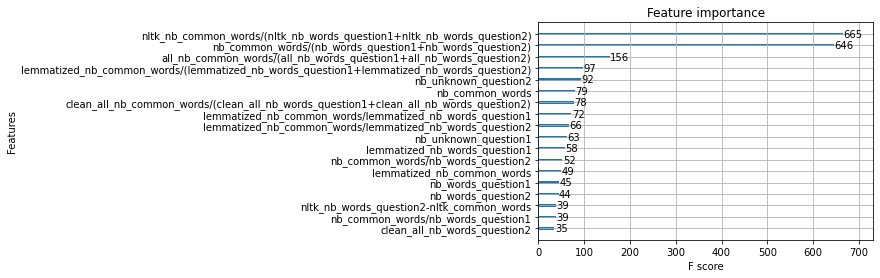

In [52]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

plot.figure(figsize=(30, 20))
xgboost.plot_importance(model,max_num_features=18)
plot.show()

Let's try to use an external source of high level data : 20newsgroup

20newsgroup is a standard dataset to demonstrate multilabel classfication on text

20000 post from 2 newsgroups are labelled with their newsgroup title

It will be very partial but if both questions are classified/not classified with the same newgroup, it can help to decide if
questions are similar or not

Newsgroup are:
* religion
* computers
* forsale
* vehicles
* sport
* science
* politics

First test is very brutal:
* all probabilities of each newsgroup for each question (training and challenge) has been computed in newgroup.ipynb
* we just add this new domain


In [53]:
copy_from_pandas_store_if_missing('train_newsgroup_proba')
copy_from_pandas_store_if_missing('challenge_newsgroup_proba')

print_info('train-dataframe has %d columns' % len(train_dataframe.columns) )
train_newsgroup_proba = load_dataframe('train_newsgroup_proba')

print_info('challenge_dataframe has %d columns' % len(challenge_dataframe.columns) )
challenge_newsgroup_proba = load_dataframe('challenge_newsgroup_proba')

# Glue them to train_dataframe & challenge_dataframe
train_dataframe = pandas.concat([train_dataframe,train_newsgroup_proba.set_index(train_dataframe.index)],axis=1)
challenge_dataframe = pandas.concat([challenge_dataframe,challenge_newsgroup_proba.set_index(challenge_dataframe.index)],axis=1)

del train_newsgroup_proba
del challenge_newsgroup_proba
print_info('train-dataframe has now %d columns' % len(train_dataframe.columns) )

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

Define our new domains

In [54]:
# everything
ALL_ALL_FEATURES = all_numeric_columns(train_dataframe)
# everything except entities
ALL_EXCEPT_PROBA = [c for c in all_numeric_columns(train_dataframe) if 'proba' not in c]
ALL_PROBA = [c for c in all_numeric_columns(train_dataframe) if 'proba' in c]
ALL_PROBA

[&#39;proba_religion_question1&#39;,
 &#39;proba_computers_question1&#39;,
 &#39;proba_forsale_question1&#39;,
 &#39;proba_vehicles_question1&#39;,
 &#39;proba_sport_question1&#39;,
 &#39;proba_science_question1&#39;,
 &#39;proba_politics_question1&#39;,
 &#39;proba_religion_question2&#39;,
 &#39;proba_computers_question2&#39;,
 &#39;proba_forsale_question2&#39;,
 &#39;proba_vehicles_question2&#39;,
 &#39;proba_sport_question2&#39;,
 &#39;proba_science_question2&#39;,
 &#39;proba_politics_question2&#39;]

In [55]:
xgboost_everything_plus_proba_newgroups_results = study_fields(
    'Everything plus proba newgroups',
    'everything_plus_proba_newgroups',
    ALL_ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore=False)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,1.000000,1.000000,1.000000,1.000000
mean,0.833875,0.786533,0.327469,89.080783
std,NaN,NaN,NaN,NaN
min,0.833875,0.786533,0.327469,89.080783
25%,0.833875,0.786533,0.327469,89.080783
50%,0.833875,0.786533,0.327469,89.080783
75%,0.833875,0.786533,0.327469,89.080783
max,0.833875,0.786533,0.327469,89.080783


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

In [56]:
all_submissions = load_kaggle_submissions()
display(get_last_submissions(all_submissions))
display(get_best_submissions(all_submissions,3))

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,date,publicScore,privateScore,description,fileName
0,2020-10-05 22:23:29,0.33712,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
2,2020-10-05 20:25:43,0.34084,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip
3,2020-10-05 20:05:27,0.33884,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip


&lt;IPython.core.display.HTML object&gt;

,publicScore,date,privateScore,description,fileName
0,0.33712,2020-10-05 22:23:29,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
3,0.33884,2020-10-05 20:05:27,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip
2,0.34084,2020-10-05 20:25:43,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip


## Another idea: use spacy's similarities coming from spacy_preprocessor.ipynb

In [59]:
copy_from_pandas_store_if_missing('train_spacy_similarity')
copy_from_pandas_store_if_missing('challenge_spacy_similarity')

print_info('train_dataframe has %d columns' % len(train_dataframe.columns) )
train_spacy_similarity = load_dataframe('train_spacy_similarity')

print_info('challenge_dataframe has %d columns' % len(challenge_dataframe.columns) )
challenge_spacy_similarity = load_dataframe('challenge_spacy_similarity')

# Glue similarities to train_dataframe & challenge_dataframe
# We have only a serie so it is much easier than with a full dataframe
train_dataframe['spacy_similarity'] = train_spacy_similarity
challenge_dataframe['spacy_similarity'] = challenge_spacy_similarity

del challenge_spacy_similarity
del train_spacy_similarity
print_info('train_dataframe has now %d columns' % len(train_dataframe.columns) )
print_info('challenge_dataframe has now %d columns' % len(challenge_dataframe.columns) )

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

Define our domains

In [62]:
# everything
ALL_ALL_FEATURES = all_numeric_columns(train_dataframe)
# everything except entities
ALL_EXCEPT_SIMILARITIES = [c for c in all_numeric_columns(train_dataframe) if 'similarity' not in c]
ALL_SIMILARITIES = [c for c in all_numeric_columns(train_dataframe) if 'similarity' in c]
ALL_SIMILARITIES

[&#39;spacy_similarity&#39;]

In [65]:
xgboost_only_similarities_results = study_fields(
    'Only similarities',
    'only_similarities',
    ALL_SIMILARITIES,
    train_dataframe,
    challenge_dataframe,
    explore=False)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,1.000000,1.000000,1.000000,1.000000
mean,0.823848,0.744278,0.421575,22.453739
std,NaN,NaN,NaN,NaN
min,0.823848,0.744278,0.421575,22.453739
25%,0.823848,0.744278,0.421575,22.453739
50%,0.823848,0.744278,0.421575,22.453739
75%,0.823848,0.744278,0.421575,22.453739
max,0.823848,0.744278,0.421575,22.453739


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

In [66]:
xgboost_all_including_similarities_results = study_fields(
    'all including similaritiess',
    'all_including_similarities',
    ALL_ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore=False)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,accuracy,score,logloss_proba,time
count,1.000000,1.000000,1.000000,1.000000
mean,0.833984,0.786622,0.326652,95.762303
std,NaN,NaN,NaN,NaN
min,0.833984,0.786622,0.326652,95.762303
25%,0.833984,0.786622,0.326652,95.762303
50%,0.833984,0.786622,0.326652,95.762303
75%,0.833984,0.786622,0.326652,95.762303
max,0.833984,0.786622,0.326652,95.762303


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

In [67]:
all_submissions = load_kaggle_submissions()
display(get_last_submissions(all_submissions))
display(get_best_submissions(all_submissions,3))

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

,date,publicScore,privateScore,description,fileName
0,2020-10-06 18:29:33,0.33623,0.33861,clean_data Best all_including_similarities,Best_all_including_similarities.zip
1,2020-10-05 22:23:29,0.33712,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
3,2020-10-05 20:25:43,0.34084,0.34305,clean_data Best everything_except_entities_xgboost,Best_everything_except_entities_xgboost.zip


&lt;IPython.core.display.HTML object&gt;

,publicScore,date,privateScore,description,fileName
0,0.33623,2020-10-06 18:29:33,0.33861,clean_data Best all_including_similarities,Best_all_including_similarities.zip
1,0.33712,2020-10-05 22:23:29,0.33934,clean_data Best everything_plus_proba_newgroups,Best_everything_plus_proba_newgroups.zip
4,0.33884,2020-10-05 20:05:27,0.34097,clean_data Best everything_xgboost,Best_everything_xgboost.zip


&lt;Figure size 2160x1440 with 0 Axes&gt;

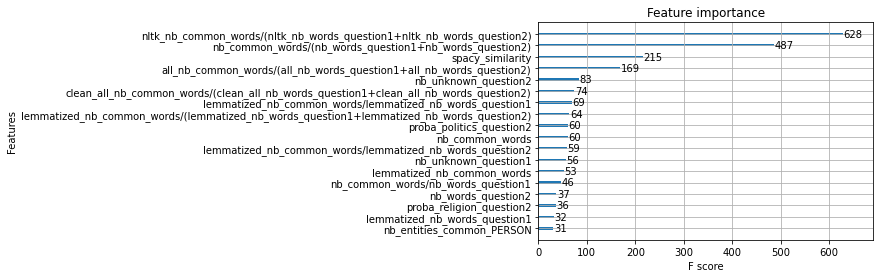

In [71]:
model = xgboost_all_including_similarities_results['model'][0]

plot.figure(figsize=(30, 20))
xgboost.plot_importance(model,max_num_features=18)
plot.show()

Calibration of the classification

In [216]:
def uncalibrated_classif(model,input_df,target_df,weights=None):
    final_input = xgboost.DMatrix(input_df) # useless to give weights here
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    # Hum shouldn't we challenge this 50% threshold ?
    prediction_df = numpy.where(prediction_proba_df>0.5,1,0)
    res = metrics.classification_report(target_df,prediction_df,sample_weight=weights,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight=weights,normalize=True)
    print_info('Classification report')
    print(metrics.classification_report(target_df,prediction_df,sample_weight=weights,))
    print_info('acc %.6f score logloss %.6f loglossproba %.6f' % (accuracy,score,logloss_proba))
    return prediction_proba_df    

input_train,input_test,target_train,target_test = train_test_split(train_dataframe,train_dataframe['is_duplicate'],random_state=42,test_size=0.2)
prediction_test_proba_df = uncalibrated_classif(model,input_test[ALL_ALL_FEATURES],target_test,input_test[WEIGHT])

# be careful this is on the splitted train not the full one
prediction_train_proba_df = uncalibrated_classif(model,input_train[ALL_ALL_FEATURES],target_train,input_train[WEIGHT])
#prediction_proba_df['pred'] = numpy.where(prediction_proba_df>0.5,1,0)

&lt;IPython.core.display.HTML object&gt;

              precision    recall  f1-score   support

           0       0.84      0.98      0.91 66475.35427891841
           1       0.63      0.14      0.22 14213.525233116525

    accuracy                           0.83 80688.87951203494
   macro avg       0.74      0.56      0.57 80688.87951203494
weighted avg       0.81      0.83      0.79 80688.87951203494



&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

              precision    recall  f1-score   support

           0       0.84      0.98      0.91 267225.6117223811
           1       0.63      0.13      0.22 56375.508766726976

    accuracy                           0.84 323601.1204891081
   macro avg       0.74      0.56      0.56 323601.1204891081
weighted avg       0.81      0.84      0.79 323601.1204891081



&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

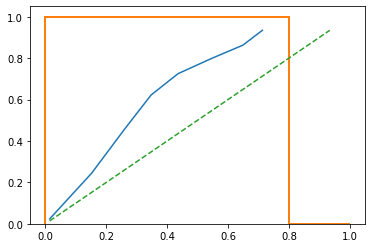

In [218]:
print_info('test mean proba %.4f' % prediction_test_proba_df.mean())
print_info('train mean proba %.4f' % prediction_train_proba_df.mean())
# default threshold 0.5
prediction_test=numpy.where(prediction_test_proba_df>0.5,1,0)
print_warning('on test %% of 1 is %.3f!!! We should have 36%% (or 17%% ?)' %prediction_test.mean())

prediction_train=numpy.where(prediction_train_proba_df>0.5,1,0)
print_warning('on train %% of 1 is %.3f!!! We should have 36%% (or 17%% ?)' %prediction_train.mean())

plot_true, plot_pred = calibration_curve(target_test, prediction_test_proba_df, strategy='quantile', n_bins=10)
plt.plot(plot_pred, plot_true)

xmin = min(plot_pred.min(), plot_true.min())
xmax = max(plot_pred.max(), plot_true.max())
plt.plot([xmin,xmax],[xmin,xmax], '--')
plt.show()


ValueError: either both or neither of x and y should be given

In [180]:
numpy.where(prediction_test_proba_df>0.3095,1,0).mean()

0.3611392812090331

In [189]:
numpy.where(prediction_test_proba_df>0.395,1,0).mean()

0.17027381335180192

&lt;IPython.core.display.HTML object&gt;

              precision    recall  f1-score   support

           0       0.92      0.82      0.87 66475.35427891841
           1       0.45      0.67      0.54 14213.525233116525

    accuracy                           0.80 80688.87951203494
   macro avg       0.68      0.75      0.70 80688.87951203494
weighted avg       0.84      0.80      0.81 80688.87951203494



&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

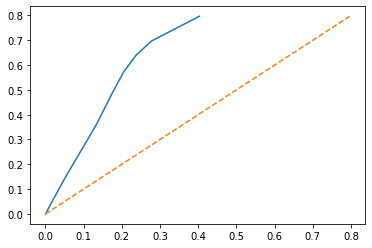

In [206]:
def calibrated_classif(model,input_df,target_df,weights=None):
    final_input = xgboost.DMatrix(input_df) # useless to give weights here
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    # Hum shouldn't we challenge this 50% threshold ?
    prediction_df = numpy.where(prediction_proba_df>0.3095,1,0)
    res = metrics.classification_report(target_df,prediction_df,sample_weight=weights,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight=weights,normalize=True)
    print_info('Classification report')
    print(metrics.classification_report(target_df,prediction_df,sample_weight=weights,))
    print_info('acc %.6f score  %.6f loglossproba %.6f' % (accuracy,score,logloss_proba))
    return prediction_proba_df 

    
input_train,input_test,target_train,target_test = train_test_split(train_dataframe,train_dataframe['is_duplicate'],random_state=42,test_size=0.2)
prediction_test_proba_df = calibrated_classif(model,input_test[ALL_ALL_FEATURES],target_test,input_test[WEIGHT])
prediction_test=numpy.where(prediction_test_proba_df>0.3095,1,0)
print_warning('on test %% of 1 is %.3f!!! We should have 36%% (or 17%% ?)' %prediction_test.mean())


prop_class_1= 0.36
y_pred_odds = 1/((1/prediction_test_proba_df)-1)
y_adj_odds = y_pred_odds * (prop_class_1 / (1-prop_class_1))
y_adj_probs = 1/ (1+ 1/y_adj_odds)



plot_true, plot_pred = calibration_curve(target_test, y_adj_probs, strategy='quantile', n_bins=10)
plt.plot(plot_pred, plot_true)
xmin = min(plot_pred.min(), plot_true.min())
xmax = max(plot_pred.max(), plot_true.max())
plt.plot([xmin,xmax],[xmin,xmax], '--')
plt.show()


In [193]:
from sklearn.calibration import calibration_curve